# Reward Competition Elo rating Calculation

## Importing other Python Libraries/Modules

In [1]:
import copy
import re
import os
import sys
import string
import glob
import ast
from collections import Counter
from collections import defaultdict
import warnings

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import git
# Getting the path of the root directory so that we can import repo specific functions
git_repo_object = git.Repo('.', search_parent_directories=True)
git_repo_directory = git_repo_object.working_tree_dir

In [4]:
# Setting path so that we can import functions
sys.path.append(os.path.join(git_repo_directory, "src"))

In [5]:
os.path.join(git_repo_directory, "src")


'/nancy/projects/dominance_strain_comparison/src'

In [6]:
from elorating import calculation
from elorating import dataframe

In [7]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

# Summary

- Experiment
    - Observing competitve behavior between two mice inside an operant chamber where tone is associated with a single liquid food reward being dispensed. Mice are prompted to compete for access to the reward.
- Data
    - Excel spreadsheet of recorded reward comeptition results. The relevant columns are those of the "Date" of the recording, the ID's of the two competing subjects, and the results for each trial. Each row will be all the trials for this pair for the recording session.
    - There are multiple cages for each sheet of the spreadsheet.
- Purpose of this Jupyter Notebook
    - To calculate the Elo rating of each mice after each interaction. The mice start off with an Elo rating of 1000. Elo ratings are calculated with the formula from here: https://www.omnicalculator.com/sports/elo . Then we will plot the change of Elo rating across all interactions. With the number of interactions on the X-Axis and the current Elo rating on the Y. There will be a line for mice.

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [8]:
protocol_name = "reward_competition"

In [9]:
prefix_name = "rc"

In [10]:
cohort_name = "pilot_2"

In [11]:
if not cohort_name:
    cohort_name = input("""Type out the name of the cohort you are using. 
                        Make sure that this is typed as one word with individual words separated by underscore. i.e. pilot_3""")

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [12]:
input_folder = os.path.join(git_repo_directory, "data")

In [13]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = 'pilot_2/*[rR]eward*'

# NOTE: If there is a set excel file used for this notebook, make the cell below into a code cell and put the path in the "" (quotation marks)

In [14]:
raw_data_file_path = "../../data/pilot_2/pilot_2_Reward_Competition_Scoring_MasterList.xlsx"

- Asking the user what the path to the recording files are, with the option of using wildcards

In [15]:
if not raw_data_file_path:
    raw_data_glob_pattern = input("""Type out the path(address) of the raw behavioral recording excel sheets.
    Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

    Globbing can also be used if you want to search with a wild card(Capitalization matters). 
    i.e. './data/*Home*' will be able to find './data/Homecage_observations.xlsx'

    NOTE: If left blank, the path will automatically be guessed off of the default settings 
    """)

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [16]:
if not raw_data_file_path:
    # Using the user inputted path/pattern
    if raw_data_glob_pattern.strip():
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern.strip(), recursive=True)
        # Checking if there were any files that matched
        if not raw_data_files_list:
            raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

    # Using the default pattern
    else:
        raw_data_glob_pattern = os.path.join(input_folder, raw_data_file_keyword)
        raw_data_files_list = glob.glob(raw_data_glob_pattern.strip(), recursive=True)
        # Searching for matching files with recursion
        if not raw_data_files_list:
            raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [17]:
if not raw_data_file_path:
    if len(raw_data_files_list) >= 2:
        raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
    else:
        # Using the first(and only file) as the file path
        raw_data_file_path = raw_data_files_list[0]

In [18]:
raw_data_file_path

'../../data/pilot_2/pilot_2_Reward_Competition_Scoring_MasterList.xlsx'

## Getting a list of all the sheets

In [19]:
# Getting the sheet names for the excel file
xls = pd.ExcelFile(raw_data_file_path)
raw_data_sheet_names = xls.sheet_names

In [20]:
raw_data_sheet_names

['Master Assignment List',
 'Naeliz',
 'Jocelyn',
 'Ezra',
 'Albert',
 'Isabel',
 'Catalina',
 'Meghan',
 'Erika',
 'Reward_Competition_Scoring_Mast',
 'reward_comp_pilo_2']

# NOTE: If there is a set sheet names used for this notebook, edit the cell below with the name of the sheets each in quotation marks seperated by commas in the brackets
   - i.e. `['CAGE 1', 'CAGE 2', 'CAGE 3', 'CAGE 4']`

In [21]:
inputted_sheet_names_list = ['Master Assignment List']

- Asking the user what sheets they want to use

In [22]:
if not inputted_sheet_names_list:
    inputted_sheet_names_string = input("""Type out the name of the sheets that you want to be processed. 
    Each name must be put in quotes and seperated by a comma(,). i.e. "CAGE3", "CAGE4"

    The available sheets are: {}

    Alternatively, you can use the index of the list of names above. 
    Remember, that Python is zero indexed so the first item will be have the 0 index, second the 1 index, and so on. 
    i.e. 1, 2

    NOTE: If left blank, all sheets will be used
    """.format(raw_data_sheet_names))

In [23]:
if not inputted_sheet_names_list:
    # Making a list out of the string of inputted sheet names
    if inputted_sheet_names_string:
        inputted_sheet_names_string = "[" + inputted_sheet_names_string + "]"
        # Turning the string into a list
        inputted_sheet_names_list = ast.literal_eval(inputted_sheet_names_string)
    # Using all the sheet names if no sheet name is specified
    else:
        inputted_sheet_names_list =  raw_data_sheet_names

In [24]:
inputted_sheet_names_list

['Master Assignment List']

- Converting all the numbers into the sheet name that the index of the number corresponds to

In [25]:
if inputted_sheet_names_list:
    for index, sheet in enumerate(inputted_sheet_names_list):
        # Checking if the sheet name was a number
        if isinstance(sheet, int) and str(sheet).isdigit():
            inputted_sheet_names_list[index] =  raw_data_sheet_names[sheet]

In [26]:
inputted_sheet_names_list

['Master Assignment List']

- Checking to see if all the sheets are in the excel file

In [27]:
if not set(inputted_sheet_names_list).issubset(raw_data_sheet_names):
    # Getting all the sheets that were not in the original spreadsheet
    not_included_sheet_names = set(inputted_sheet_names_list) - set(raw_data_sheet_names)
    raise ValueError("All the listed sheet names are not in {}".format(not_included_sheet_names))

## Finding the row for the header

- Headers are the row in a spreadsheet that has all the column names. Sometimes spreadsheets don't use the first row as the row with the column names. So, the row for the header will be asked or assumed to be the first row

# NOTE: If there is a set row that has the column names, then enter the row number in the quotation marks

In [28]:
# Making the row number a string, so that "0" is treated as a True value
all_header_row = "0"
if not all_header_row:
    all_header_row = False
else:
    all_header_row = int(all_header_row)


In [29]:
sheet_name_to_everything = defaultdict(dict)
for sheet in inputted_sheet_names_list:
    if all_header_row is False:

        print("\nCurrent Sheet Name: {}".format(sheet))    
        per_sheet_dataframe = pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0)

        # Showing the columns that are chosen with the header being the 0th row
        print("Columns Names: {}".format(per_sheet_dataframe.columns))
        # Show the dataframe that would be created with the header being the 0th row
        print("First few rows of this dataframe:")
        print(pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0).head())

        # Allowing the user the choose the row number for the header
        header_row = input("""Type the row number to be used as the header
        (AKA the row with the column name that you want to use.)
        If you want to keep the column names that were displayed, type 0.
        If you want to use a different row, then type the corresponding number. 

        The rows displayed in this cell are dataframes created from Pandas. 
        To use the row with the 0 index for column names, type 1. 
        For the row with the 1 index, it will be 2 and so on. i.e. 2

        If you are looking at the original spread sheet, remember that Python is zero indexed. 
        So the first row will be 0, second will be 1, and so on. 
        i.e. 1

        NOTE: If left blank, the original row that was used will be used.
        """).strip()

        if header_row == "":
            header_row = 0
        else:
            header_row = int(header_row)
    else:
        header_row = all_header_row
    
    # Checking if any of the column names are from empty cells
    column_names = "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=header_row).columns])
    # If a column name came from an empty cell, it would have "Unnamed" in it
    if "Unnamed" in column_names:
        raise ValueError("""Not all the cells in the chosen row are filled in.
                         Please choose a row that has the name of the columns
                         
                         The values in this row are: {}""".format(column_names))
    else:
        sheet_name_to_everything[sheet]["header_row"] = header_row

In [30]:
sheet_name_to_everything

defaultdict(dict, {'Master Assignment List': {'header_row': 0}})

## Reading in all the spreadsheets

In [31]:
# Going through each sheet and creating a dataframe of it
for key, value in sheet_name_to_everything.items():
    value["original_behavior_recording_dataframe"] = pd.read_excel(raw_data_file_path, sheet_name=key, header=value["header_row"])

In [32]:
value["original_behavior_recording_dataframe"].head()

,Date,Cage,Box,Match,Scorer,Trial 1 Time,Trial 1 Winner,Trial 2 Time,Trial 2 Winner,Trial 3 Time,...,Trial 17 Time,Trial 17 Winner,Trial 18 Time,Trial 18 Winner,Trial 19 Time,Trial 19 Winner,Mouse 1 Wins,Mouse 2 Wins,Ties,
0,2022-07-28,1,1,1.1v1.2,Naeliz,0:48-0:58,1.2,1:56-2:04,1.1,3:09-3:18,...,20:53-21:00,1.1,22:33-22:42,1.1,23:39-23:47,1.1,10.0,8.0,1.1,NaN
1,2022-07-28,1,2,1.3v1.4,Erika,0:47-0:53,1.3,1:54-2:00,1.4,3:09-3:15,...,20:53-20:59,1.3,22:33-22:39,1.4,23:39-23:45,1.4,8.0,11.0,0.0,NaN
2,2022-07-28,1,3,1.2v1.3,Ezra,00:37-00:43,1.2,1:31-1:37,1.2,2:30-2:36,...,16:42-16:48,1.3,18:02-18:08,tie,18:55-19:01,tie,12.0,1.3,1.4,NaN
3,2022-07-28,1,4,1.1v1.4,Isabel,0:37-0:44,1.1,1:31-1:38,1.1,2:31-2:38,...,16:43-16:49,1.4,18:02-18:09,1.1,20:36-20:43,1.1,18.0,1.1,NaN,NaN
4,2022-07-28,1,1,1.2v1.4,Catalina,0:47 - 0:56,1.2,1:54 - 2:02,1.2,3:09 - 3:17,...,20:52 - 21:00,1.2,22:32 - 22:40,tie,23:39 - 23:47,tie,11.0,1.3,5.0,NaN


In [33]:
value["original_behavior_recording_dataframe"].tail()

,Date,Cage,Box,Match,Scorer,Trial 1 Time,Trial 1 Winner,Trial 2 Time,Trial 2 Winner,Trial 3 Time,...,Trial 17 Time,Trial 17 Winner,Trial 18 Time,Trial 18 Winner,Trial 19 Time,Trial 19 Winner,Mouse 1 Wins,Mouse 2 Wins,Ties,
67,2022-07-29,6,2,6.2v6.4,Isabel,0:46-0:53,6.4,1:51-1:59,6.4,3:06-3:14,...,20:41-20:50,6.4,22:21-22:30,6.4,23:28-23:36,6.4,0.0,19.0,0.0,NaN
68,2022-07-29,6,3,6.1v6.4,Catalina,0:44 - 0:52,6.1,1:50 - 1:59,6.1,3:05 - 3:13,...,20:00 - 20:07,6.1,21:35 - 21:44,6.1,22:42 - 22:49,6.1,16.0,6.2,6.1,NaN
69,2022-07-29,6,4,6.2v6.3,Erika,0:39-0:45,6.2,1:32-1:38,6.3,2:32-2:38,...,16:44-16:50,6.3,18:04-18:10,6.3,18:58-19:04,6.3,8.0,11.0,0.0,NaN
70,2022-07-29,6,1,6.3v6.4,Ezra,00:39-00:46,6.4,1:45-1:53,tie,3:01-3:08,...,20:44-20:51,6.4,22:24-22:31,tie,23:30-23:38,6.3,11.0,6.4,4.0,NaN
71,2022-07-29,6,1,6.1v6.2,Jocelyn,0:47-0:54,6.1,1:54-2:01,6.1,3:12-3:19,...,23:44-23:53,6.2,25:44-25:52,6.1,27:03-27:12,6.1,9.0,9.0,6.1,NaN


## Standarizing the Columns

- Making all the column names lower case and removing any extra spaces in the beginning and at the end
    - One dictionary per sheet

In [34]:
for key, value in sheet_name_to_everything.items():
    # Creating a dictionary that maps the original column name to the standarized one
    column_name_to_standarized = defaultdict(dict)
    for col in value["original_behavior_recording_dataframe"]:
        # Making the column name lower case and removing the spaces
        column_name_to_standarized[col] = "_".join(str(col).lower().strip().split(" "))
    value["column_name_to_standarized"] = column_name_to_standarized

In [35]:
value["column_name_to_standarized"]

defaultdict(dict,
            {'Date': 'date',
             'Cage': 'cage',
             'Box': 'box',
             'Match': 'match',
             'Scorer': 'scorer',
             'Trial 1 Time': 'trial_1_time',
             'Trial 1 Winner': 'trial_1_winner',
             'Trial 2 Time': 'trial_2_time',
             'Trial 2 Winner': 'trial_2_winner',
             'Trial 3 Time': 'trial_3_time',
             'Trial 3 Winner': 'trial_3_winner',
             'Trial 4 Time': 'trial_4_time',
             'Trial 4 Winner': 'trial_4_winner',
             'Trial 5 Time': 'trial_5_time',
             'Trial 5 Winner': 'trial_5_winner',
             'Trial 6 Time': 'trial_6_time',
             'Trial 6 Winner': 'trial_6_winner',
             'Trial 7 Time': 'trial_7_time',
             'Trial 7 Winner': 'trial_7_winner',
             'Trial 8 Time': 'trial_8_time',
             'Trial 8 Winner': 'trial_8_winner',
             'Trial 9 Time': 'trial_9_time',
             'Trial 9 Winner': 'tria

In [36]:
# Renaming all the columns to the lower case and space removed version
for key, value in sheet_name_to_everything.items():
    value["processed_behavior_recording_dataframe"] = value["original_behavior_recording_dataframe"].rename(columns=value["column_name_to_standarized"])
    value["processed_behavior_recording_dataframe"]["sheet_name"] = key

In [37]:
value["processed_behavior_recording_dataframe"].head()

,date,cage,box,match,scorer,trial_1_time,trial_1_winner,trial_2_time,trial_2_winner,trial_3_time,...,trial_17_winner,trial_18_time,trial_18_winner,trial_19_time,trial_19_winner,mouse_1_wins,mouse_2_wins,ties,,sheet_name
0,2022-07-28,1,1,1.1v1.2,Naeliz,0:48-0:58,1.2,1:56-2:04,1.1,3:09-3:18,...,1.1,22:33-22:42,1.1,23:39-23:47,1.1,10.0,8.0,1.1,NaN,Master Assignment List
1,2022-07-28,1,2,1.3v1.4,Erika,0:47-0:53,1.3,1:54-2:00,1.4,3:09-3:15,...,1.3,22:33-22:39,1.4,23:39-23:45,1.4,8.0,11.0,0.0,NaN,Master Assignment List
2,2022-07-28,1,3,1.2v1.3,Ezra,00:37-00:43,1.2,1:31-1:37,1.2,2:30-2:36,...,1.3,18:02-18:08,tie,18:55-19:01,tie,12.0,1.3,1.4,NaN,Master Assignment List
3,2022-07-28,1,4,1.1v1.4,Isabel,0:37-0:44,1.1,1:31-1:38,1.1,2:31-2:38,...,1.4,18:02-18:09,1.1,20:36-20:43,1.1,18.0,1.1,NaN,NaN,Master Assignment List
4,2022-07-28,1,1,1.2v1.4,Catalina,0:47 - 0:56,1.2,1:54 - 2:02,1.2,3:09 - 3:17,...,1.2,22:32 - 22:40,tie,23:39 - 23:47,tie,11.0,1.3,5.0,NaN,Master Assignment List


In [38]:
reward_competition_df = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]

In [39]:
reward_competition_df.columns

Index(['date', 'cage', 'box', 'match', 'scorer', 'trial_1_time',
       'trial_1_winner', 'trial_2_time', 'trial_2_winner', 'trial_3_time',
       'trial_3_winner', 'trial_4_time', 'trial_4_winner', 'trial_5_time',
       'trial_5_winner', 'trial_6_time', 'trial_6_winner', 'trial_7_time',
       'trial_7_winner', 'trial_8_time', 'trial_8_winner', 'trial_9_time',
       'trial_9_winner', 'trial_10_time', 'trial_10_winner', 'trial_11_time',
       'trial_11_winner', 'trial_12_time', 'trial_12_winner', 'trial_13_time',
       'trial_13_winner', 'trial_14_time', 'trial_14_winner', 'trial_15_time',
       'trial_15_winner', 'trial_16_time', 'trial_16_winner', 'trial_17_time',
       'trial_17_winner', 'trial_18_time', 'trial_18_winner', 'trial_19_time',
       'trial_19_winner', 'mouse_1_wins', 'mouse_2_wins', 'ties', '',
       'sheet_name'],
      dtype='object')

- Removing unnecessary columns

In [40]:
reward_competition_df = reward_competition_df.drop([col for col in reward_competition_df.columns if "wins" in col or "ties" in col], axis=1, errors="ignore")

In [41]:
columns_to_keep = [col for col in reward_competition_df.columns if "time" not in col.lower().strip()]

In [42]:
columns_to_keep

['date',
 'cage',
 'box',
 'match',
 'scorer',
 'trial_1_winner',
 'trial_2_winner',
 'trial_3_winner',
 'trial_4_winner',
 'trial_5_winner',
 'trial_6_winner',
 'trial_7_winner',
 'trial_8_winner',
 'trial_9_winner',
 'trial_10_winner',
 'trial_11_winner',
 'trial_12_winner',
 'trial_13_winner',
 'trial_14_winner',
 'trial_15_winner',
 'trial_16_winner',
 'trial_17_winner',
 'trial_18_winner',
 'trial_19_winner',
 '',
 'sheet_name']

In [43]:
reward_competition_df = reward_competition_df[columns_to_keep].copy()

In [44]:
reward_competition_df.head()

,date,cage,box,match,scorer,trial_1_winner,trial_2_winner,trial_3_winner,trial_4_winner,trial_5_winner,...,trial_12_winner,trial_13_winner,trial_14_winner,trial_15_winner,trial_16_winner,trial_17_winner,trial_18_winner,trial_19_winner,,sheet_name
0,2022-07-28,1,1,1.1v1.2,Naeliz,1.2,1.1,1.1,1.2,1.2,...,1.2,1.1,1.1,1.2,1.1,1.1,1.1,1.1,NaN,Master Assignment List
1,2022-07-28,1,2,1.3v1.4,Erika,1.3,1.4,1.4,1.3,1.4,...,1.3,1.3,1.4,1.3,1.3,1.3,1.4,1.4,NaN,Master Assignment List
2,2022-07-28,1,3,1.2v1.3,Ezra,1.2,1.2,1.2,1.2,1.2,...,1.2,tie,1.2,1.3,tie,1.3,tie,tie,NaN,Master Assignment List
3,2022-07-28,1,4,1.1v1.4,Isabel,1.1,1.1,1.1,1.1,1.1,...,1.1,1.1,1.1,1.1,1.1,1.4,1.1,1.1,NaN,Master Assignment List
4,2022-07-28,1,1,1.2v1.4,Catalina,1.2,1.2,1.4,1.2,1.4,...,1.2,tie,tie,tie,1.2,1.2,tie,tie,NaN,Master Assignment List


In [45]:
reward_competition_df = reward_competition_df.dropna(subset=["trial_1_winner"])

## Add both IDs as a column

In [46]:
reward_competition_df["animal_ids"] = reward_competition_df["match"].apply(lambda x: tuple(sorted([all_ids.strip() for all_ids in re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)])))

In [47]:
reward_competition_df.head()

,date,cage,box,match,scorer,trial_1_winner,trial_2_winner,trial_3_winner,trial_4_winner,trial_5_winner,...,trial_13_winner,trial_14_winner,trial_15_winner,trial_16_winner,trial_17_winner,trial_18_winner,trial_19_winner,,sheet_name,animal_ids
0,2022-07-28,1,1,1.1v1.2,Naeliz,1.2,1.1,1.1,1.2,1.2,...,1.1,1.1,1.2,1.1,1.1,1.1,1.1,NaN,Master Assignment List,"(1.1, 1.2)"
1,2022-07-28,1,2,1.3v1.4,Erika,1.3,1.4,1.4,1.3,1.4,...,1.3,1.4,1.3,1.3,1.3,1.4,1.4,NaN,Master Assignment List,"(1.3, 1.4)"
2,2022-07-28,1,3,1.2v1.3,Ezra,1.2,1.2,1.2,1.2,1.2,...,tie,1.2,1.3,tie,1.3,tie,tie,NaN,Master Assignment List,"(1.2, 1.3)"
3,2022-07-28,1,4,1.1v1.4,Isabel,1.1,1.1,1.1,1.1,1.1,...,1.1,1.1,1.1,1.1,1.4,1.1,1.1,NaN,Master Assignment List,"(1.1, 1.4)"
4,2022-07-28,1,1,1.2v1.4,Catalina,1.2,1.2,1.4,1.2,1.4,...,tie,tie,tie,1.2,1.2,tie,tie,NaN,Master Assignment List,"(1.2, 1.4)"


In [48]:
reward_competition_df["cohort"] = cohort_name

- Adding strain information

In [49]:
cage_to_strain = {"1": "C57", "2": "C57", "3": "C57", "4": "CD1", "5": "CD1", "6": "CD1"}

# NOTE: If there are strains that are associated to each cage, then create a dictionary of cage numbers to strains inside the `{}`
- i.e. `cage_to_strain = {"1": "C57", "2": "C57", "3": "C57", "4": "CD1", "5": "CD1", "6": "CD1"}`

In [50]:
reward_competition_df["strain"] = reward_competition_df["cage"].astype(str).map(cage_to_strain)

In [51]:
all_cages = "_".join([str(cage) for cage in sorted(reward_competition_df["cage"].unique())])

In [52]:
all_cages

'1_2_3_4_5_6'

In [53]:
earliest_date = reward_competition_df["date"].min()
latest_date = reward_competition_df["date"].max()

In [54]:
earliest_date = str(earliest_date.date()).replace("-", "")

In [55]:
latest_date = str(latest_date.date()).replace("-", "")

In [56]:
earliest_date

'20220728'

In [57]:
latest_date

'20220729'

- Creating a subfolder to put the Elo rating Spreadsheets

In [58]:
elo_rating_spreadsheet_output_directory = os.path.join(".", "proc", "elo_rating_spread_sheets", "{}".format(protocol_name))

In [59]:
elo_rating_spreadsheet_output_directory

'./proc/elo_rating_spread_sheets/reward_competition'

In [60]:
os.makedirs(elo_rating_spreadsheet_output_directory, exist_ok=True)

In [61]:
file_name = "{}_{}_trial_as_columns_cages_{}_date_{}_{}.csv".format(cohort_name, protocol_name, all_cages, earliest_date, latest_date)

reward_competition_df.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name))

In [62]:
reward_competition_df = reward_competition_df.drop(columns=["sheet_name", "scorer"], errors="ignore")

## Melt 

In [63]:
reward_competition_df["index"] = reward_competition_df.index
reward_competition_df = reward_competition_df.reset_index(drop=True)

In [64]:
reward_competition_df.head()

,date,cage,box,match,trial_1_winner,trial_2_winner,trial_3_winner,trial_4_winner,trial_5_winner,trial_6_winner,...,trial_15_winner,trial_16_winner,trial_17_winner,trial_18_winner,trial_19_winner,,animal_ids,cohort,strain,index
0,2022-07-28,1,1,1.1v1.2,1.2,1.1,1.1,1.2,1.2,tie,...,1.2,1.1,1.1,1.1,1.1,NaN,"(1.1, 1.2)",pilot_2,C57,0
1,2022-07-28,1,2,1.3v1.4,1.3,1.4,1.4,1.3,1.4,1.4,...,1.3,1.3,1.3,1.4,1.4,NaN,"(1.3, 1.4)",pilot_2,C57,1
2,2022-07-28,1,3,1.2v1.3,1.2,1.2,1.2,1.2,1.2,1.2,...,1.3,tie,1.3,tie,tie,NaN,"(1.2, 1.3)",pilot_2,C57,2
3,2022-07-28,1,4,1.1v1.4,1.1,1.1,1.1,1.1,1.1,1.1,...,1.1,1.1,1.4,1.1,1.1,NaN,"(1.1, 1.4)",pilot_2,C57,3
4,2022-07-28,1,1,1.2v1.4,1.2,1.2,1.4,1.2,1.4,1.2,...,tie,1.2,1.2,tie,tie,NaN,"(1.2, 1.4)",pilot_2,C57,4


In [65]:
melted_reward_competition_df = reward_competition_df.melt(id_vars=["index", "date", "cage", "box", "match", "animal_ids"], 
        var_name="trial", 
        value_name="winner")

In [66]:
melted_reward_competition_df.head()

,index,date,cage,box,match,animal_ids,trial,winner
0,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_1_winner,1.2
1,1,2022-07-28,1,2,1.3v1.4,"(1.3, 1.4)",trial_1_winner,1.3
2,2,2022-07-28,1,3,1.2v1.3,"(1.2, 1.3)",trial_1_winner,1.2
3,3,2022-07-28,1,4,1.1v1.4,"(1.1, 1.4)",trial_1_winner,1.1
4,4,2022-07-28,1,1,1.2v1.4,"(1.2, 1.4)",trial_1_winner,1.2


In [67]:
melted_reward_competition_df.tail()

,index,date,cage,box,match,animal_ids,trial,winner
1579,67,2022-07-29,6,2,6.2v6.4,"(6.2, 6.4)",strain,CD1
1580,68,2022-07-29,6,3,6.1v6.4,"(6.1, 6.4)",strain,CD1
1581,69,2022-07-29,6,4,6.2v6.3,"(6.2, 6.3)",strain,CD1
1582,70,2022-07-29,6,1,6.3v6.4,"(6.3, 6.4)",strain,CD1
1583,71,2022-07-29,6,1,6.1v6.2,"(6.1, 6.2)",strain,CD1


- Dropping all rows that don't contain Winner

In [68]:
melted_reward_competition_df = melted_reward_competition_df.dropna(subset="winner")

In [69]:
melted_reward_competition_df["winner"].unique()

array([1.2, 1.3, 1.1, 2.1, 2.3, 3.2, 3.4, 3.1, 4.1, 4.4, 4.3, 4.2, 'tie',
       5.1, 5.4, 5.3, 5.2, 6.1, 6.3, 6.2, 6.4, 1.4, 2.2, 2.4, 3.3,
       'pilot_2', 'C57', 'CD1'], dtype=object)

In [70]:
melted_reward_competition_df["keep_row"] = melted_reward_competition_df["winner"].apply(lambda x: True if "tie" in str(x).lower() or re.match(r'^-?\d+(?:\.\d+)$', str(x)) else False)

In [71]:
melted_reward_competition_df = melted_reward_competition_df[melted_reward_competition_df["keep_row"]]

In [72]:
melted_reward_competition_df["winner"].unique()

array([1.2, 1.3, 1.1, 2.1, 2.3, 3.2, 3.4, 3.1, 4.1, 4.4, 4.3, 4.2, 'tie',
       5.1, 5.4, 5.3, 5.2, 6.1, 6.3, 6.2, 6.4, 1.4, 2.2, 2.4, 3.3],
      dtype=object)

- Making all the ids into string

In [73]:
melted_reward_competition_df["winner"] = melted_reward_competition_df["winner"].astype(str)
melted_reward_competition_df["winner"] = melted_reward_competition_df["winner"].apply(lambda x: x.lower().strip())

In [74]:
melted_reward_competition_df["animal_ids"].unique()

array([('1.1', '1.2'), ('1.3', '1.4'), ('1.2', '1.3'), ('1.1', '1.4'),
       ('1.2', '1.4'), ('1.1', '1.3'), ('2.1', '2.2'), ('2.3', '2.4'),
       ('2.2', '2.3'), ('2.1', '2.4'), ('2.2', '2.4'), ('2.1', '2.3'),
       ('3.1', '3.2'), ('3.3', '3.4'), ('3.2', '3.3'), ('3.1', '3.4'),
       ('3.2', '3.4'), ('3.1', '3.3'), ('4.1', '4.2'), ('4.3', '4.4'),
       ('4.2', '4.3'), ('4.1', '4.4'), ('4.2', '4.4'), ('4.1', '4.3'),
       ('5.1', '5.2'), ('5.3', '5.4'), ('5.2', '5.3'), ('5.1', '5.4'),
       ('5.2', '5.4'), ('5.1', '5.3'), ('6.1', '6.2'), ('6.3', '6.4'),
       ('6.2', '6.3'), ('6.1', '6.4'), ('6.2', '6.4'), ('6.1', '6.3')],
      dtype=object)

- Making a different column for ties

In [75]:
melted_reward_competition_df["match_is_tie"] = melted_reward_competition_df["winner"].apply(lambda x: True if "tie" in x.lower().strip() else False)

- Replacing tie with the first animal id for elo score plotting

In [76]:
melted_reward_competition_df["winner"] = melted_reward_competition_df.apply(lambda x: x["animal_ids"][0] if x["match_is_tie"] else x["winner"], axis=1)

In [77]:
melted_reward_competition_df[melted_reward_competition_df["match_is_tie"]]

,index,date,cage,box,match,animal_ids,trial,winner,keep_row,match_is_tie
23,23,2022-07-28,4,4,4.1v4.3,"(4.1, 4.3)",trial_1_winner,4.1,True,True
35,35,2022-07-28,6,4,6.1v6.3,"(6.1, 6.3)",trial_1_winner,6.1,True,True
100,28,2022-07-28,5,1,5.2v5.4,"(5.2, 5.4)",trial_2_winner,5.2,True,True
137,65,2022-07-29,5,3,5.1v5.2,"(5.1, 5.2)",trial_2_winner,5.1,True,True
142,70,2022-07-29,6,1,6.3v6.4,"(6.3, 6.4)",trial_2_winner,6.3,True,True
...,...,...,...,...,...,...,...,...,...,...
1298,2,2022-07-28,1,3,1.2v1.3,"(1.2, 1.3)",trial_19_winner,1.2,True,True
1300,4,2022-07-28,1,1,1.2v1.4,"(1.2, 1.4)",trial_19_winner,1.2,True,True
1325,29,2022-07-28,5,2,5.1v5.3,"(5.1, 5.3)",trial_19_winner,5.1,True,True
1331,35,2022-07-28,6,4,6.1v6.3,"(6.1, 6.3)",trial_19_winner,6.1,True,True


- Dropping all rows that don't have trial in the name for the trial section

In [78]:
melted_reward_competition_df = melted_reward_competition_df[melted_reward_competition_df["trial"].str.contains('trial')]

- Getting the number of the trial so that we can order by number(instead of string, which would make 11 come before 2)

In [79]:
melted_reward_competition_df["trial_number"] = melted_reward_competition_df["trial"].apply(lambda x: int(x.lower().strip("trial").strip("winner").strip("_")))

In [80]:
melted_reward_competition_df = melted_reward_competition_df.sort_values(["index", "trial_number"]).reset_index(drop=True)

In [81]:
melted_reward_competition_df.head()

,index,date,cage,box,match,animal_ids,trial,winner,keep_row,match_is_tie,trial_number
0,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_1_winner,1.2,True,False,1
1,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_2_winner,1.1,True,False,2
2,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_3_winner,1.1,True,False,3
3,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_4_winner,1.2,True,False,4
4,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_5_winner,1.2,True,False,5


In [82]:
melted_reward_competition_df.head(n=100)

,index,date,cage,box,match,animal_ids,trial,winner,keep_row,match_is_tie,trial_number
0,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_1_winner,1.2,True,False,1
1,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_2_winner,1.1,True,False,2
2,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_3_winner,1.1,True,False,3
3,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_4_winner,1.2,True,False,4
4,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_5_winner,1.2,True,False,5
...,...,...,...,...,...,...,...,...,...,...,...
95,5,2022-07-28,1,2,1.1v1.3,"(1.1, 1.3)",trial_1_winner,1.1,True,False,1
96,5,2022-07-28,1,2,1.1v1.3,"(1.1, 1.3)",trial_2_winner,1.3,True,False,2
97,5,2022-07-28,1,2,1.1v1.3,"(1.1, 1.3)",trial_3_winner,1.1,True,False,3
98,5,2022-07-28,1,2,1.1v1.3,"(1.1, 1.3)",trial_4_winner,1.1,True,False,4


In [83]:
melted_reward_competition_df["trial_number"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

## Add a column for the loser ID

In [84]:
melted_reward_competition_df.columns

Index(['index', 'date', 'cage', 'box', 'match', 'animal_ids', 'trial',
       'winner', 'keep_row', 'match_is_tie', 'trial_number'],
      dtype='object')

In [85]:
melted_reward_competition_df.head()

,index,date,cage,box,match,animal_ids,trial,winner,keep_row,match_is_tie,trial_number
0,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_1_winner,1.2,True,False,1
1,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_2_winner,1.1,True,False,2
2,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_3_winner,1.1,True,False,3
3,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_4_winner,1.2,True,False,4
4,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_5_winner,1.2,True,False,5


In [86]:
melted_reward_competition_df["loser"] = melted_reward_competition_df.apply(lambda x: (list(set(x["animal_ids"]) - set([x["winner"]]))[0]), axis=1)

In [87]:
melted_reward_competition_df["loser"].unique()

array(['1.1', '1.2', '1.4', '1.3', '2.2', '2.4', '2.3', '2.1', '3.1',
       '3.2', '3.3', '3.4', '4.2', '4.1', '4.3', '4.4', '5.2', '5.1',
       '5.3', '5.4', '6.2', '6.1', '6.4', '6.3'], dtype=object)

In [88]:
melted_reward_competition_df.head(n=5)

,index,date,cage,box,match,animal_ids,trial,winner,keep_row,match_is_tie,trial_number,loser
0,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_1_winner,1.2,True,False,1,1.1
1,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_2_winner,1.1,True,False,2,1.2
2,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_3_winner,1.1,True,False,3,1.2
3,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_4_winner,1.2,True,False,4,1.1
4,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_5_winner,1.2,True,False,5,1.1


In [89]:
melted_reward_competition_df.tail(n=5)

,index,date,cage,box,match,animal_ids,trial,winner,keep_row,match_is_tie,trial_number,loser
1363,71,2022-07-29,6,1,6.1v6.2,"(6.1, 6.2)",trial_15_winner,6.2,True,False,15,6.1
1364,71,2022-07-29,6,1,6.1v6.2,"(6.1, 6.2)",trial_16_winner,6.2,True,False,16,6.1
1365,71,2022-07-29,6,1,6.1v6.2,"(6.1, 6.2)",trial_17_winner,6.2,True,False,17,6.1
1366,71,2022-07-29,6,1,6.1v6.2,"(6.1, 6.2)",trial_18_winner,6.1,True,False,18,6.2
1367,71,2022-07-29,6,1,6.1v6.2,"(6.1, 6.2)",trial_19_winner,6.1,True,False,19,6.2


## Adding the session number

- We are adding the session number to all the trials. The session number is counting the number of recording sessions that have happened up until that trial. Usually, each session in the spreadsheet is divided up by a session's first row having the date filled in. So we will label a new session when a date is filled in.

# Getting the Session number differences

- Getting the indexes of where each new session starts. So that we can add the session number to each row.

In [90]:
melted_reward_competition_df["session_number_difference"] = melted_reward_competition_df["date"].astype('category').cat.codes.diff()


## Calculating Elo rating

- Example calculation

In [91]:
calculation.calculate_elo_rating(subject_elo_rating=1000, agent_elo_rating=2000, score=1)

1019.9

In [92]:
calculation.update_elo_rating(winner_id="A", loser_id="B")

defaultdict(<function elorating.calculation.update_elo_rating.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

## Get the Elo rating for all the events

- Going through each row or interaction and calculating the new Elo rating for the winner and loser. This will create a new dataframe based off of the processed behavioral recording dataframe

In [93]:
cage_to_elo_rating_dict = defaultdict(dict)
for cage in melted_reward_competition_df["cage"].unique():
    cage_df = melted_reward_competition_df[melted_reward_competition_df["cage"] == cage]
    cage_to_elo_rating_dict[cage] = calculation.iterate_elo_rating_calculation_for_dataframe(dataframe=cage_df, winner_id_column="winner", loser_id_column="loser", additional_columns=melted_reward_competition_df.columns, tie_column="match_is_tie")

In [94]:
cage_to_elo_rating_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6])

In [95]:
cage_to_elo_rating_dict[list(cage_to_elo_rating_dict.keys())[0]][0]

{'total_match_number': 1,
 'subject_id': '1.2',
 'agent_id': '1.1',
 'original_elo_rating': 1000,
 'updated_elo_rating': 1010.0,
 'win_draw_loss': 1,
 'subject_ranking': 1,
 'agent_ranking': 2,
 'pairing_index': 0,
 'index': 0,
 'date': Timestamp('2022-07-28 00:00:00'),
 'cage': 1,
 'box': 1,
 'match': '1.1v1.2',
 'animal_ids': ('1.1', '1.2'),
 'trial': 'trial_1_winner',
 'winner': '1.2',
 'keep_row': True,
 'match_is_tie': False,
 'trial_number': 1,
 'loser': '1.1',
 'session_number_difference': nan}

- Turning the dictionary into a dataframe

In [96]:
all_cage_elo_rating_list = []
for key in cage_to_elo_rating_dict.keys():
    cage_elo_rating_df = pd.DataFrame.from_dict(cage_to_elo_rating_dict[key], orient="index")
    cage_elo_rating_df.insert(0, 'total_trial_number', range(0, 0 + len(cage_elo_rating_df)))
    print(cage_elo_rating_df)
    all_cage_elo_rating_list.append(cage_elo_rating_df)


     total_trial_number  total_match_number subject_id agent_id  \
0                     0                   1        1.2      1.1   
1                     1                   1        1.1      1.2   
2                     2                   2        1.1      1.2   
3                     3                   2        1.2      1.1   
4                     4                   3        1.1      1.2   
..                  ...                 ...        ...      ...   
451                 451                 226        1.2      1.1   
452                 452                 227        1.1      1.2   
453                 453                 227        1.2      1.1   
454                 454                 228        1.1      1.2   
455                 455                 228        1.2      1.1   

     original_elo_rating  updated_elo_rating  win_draw_loss  subject_ranking  \
0                 1000.0              1010.0            1.0                1   
1                 1000.0           

In [97]:
all_cage_elo_rating_df = pd.concat(all_cage_elo_rating_list)

In [98]:
all_cage_elo_rating_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,...,box,match,animal_ids,trial,winner,keep_row,match_is_tie,trial_number,loser,session_number_difference
0,0,1,1.2,1.1,1000.0,1010.0,1.0,1,2,0,...,1,1.1v1.2,"(1.1, 1.2)",trial_1_winner,1.2,True,False,1,1.1,NaN
1,1,1,1.1,1.2,1000.0,990.0,0.0,2,1,1,...,1,1.1v1.2,"(1.1, 1.2)",trial_1_winner,1.2,True,False,1,1.1,NaN
2,2,2,1.1,1.2,990.0,1000.6,1.0,1,2,0,...,1,1.1v1.2,"(1.1, 1.2)",trial_2_winner,1.1,True,False,2,1.2,0.0
3,3,2,1.2,1.1,1010.0,999.4,0.0,2,1,1,...,1,1.1v1.2,"(1.1, 1.2)",trial_2_winner,1.1,True,False,2,1.2,0.0
4,4,3,1.1,1.2,1000.6,1010.6,1.0,1,2,0,...,1,1.1v1.2,"(1.1, 1.2)",trial_3_winner,1.1,True,False,3,1.2,0.0


In [99]:
all_cage_elo_rating_df.tail()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,...,box,match,animal_ids,trial,winner,keep_row,match_is_tie,trial_number,loser,session_number_difference
451,451,226,6.1,6.2,1102.8,1088.6,0.0,1,3,1,...,1,6.1v6.2,"(6.1, 6.2)",trial_17_winner,6.2,True,False,17,6.1,0.0
452,452,227,6.1,6.2,1088.6,1095.1,1.0,1,3,0,...,1,6.1v6.2,"(6.1, 6.2)",trial_18_winner,6.1,True,False,18,6.2,0.0
453,453,227,6.2,6.1,961.4,954.9,0.0,3,1,1,...,1,6.1v6.2,"(6.1, 6.2)",trial_18_winner,6.1,True,False,18,6.2,0.0
454,454,228,6.1,6.2,1095.1,1101.3,1.0,1,3,0,...,1,6.1v6.2,"(6.1, 6.2)",trial_19_winner,6.1,True,False,19,6.2,0.0
455,455,228,6.2,6.1,954.9,948.7,0.0,3,1,1,...,1,6.1v6.2,"(6.1, 6.2)",trial_19_winner,6.1,True,False,19,6.2,0.0


In [100]:
all_cage_elo_rating_df[all_cage_elo_rating_df["match_is_tie"]]

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,...,box,match,animal_ids,trial,winner,keep_row,match_is_tie,trial_number,loser,session_number_difference
10,10,6,1.1,1.2,990.0,990.6,0.5,2,1,0,...,1,1.1v1.2,"(1.1, 1.2)",trial_6_winner,1.1,True,True,6,1.2,0.0
11,11,6,1.2,1.1,1010.0,1009.4,0.5,1,2,1,...,1,1.1v1.2,"(1.1, 1.2)",trial_6_winner,1.1,True,True,6,1.2,0.0
100,100,51,1.2,1.3,1048.7,1044.8,0.5,1,4,0,...,3,1.2v1.3,"(1.2, 1.3)",trial_13_winner,1.2,True,True,13,1.3,0.0
101,101,51,1.3,1.2,907.3,911.2,0.5,4,1,1,...,3,1.2v1.3,"(1.2, 1.3)",trial_13_winner,1.2,True,True,13,1.3,0.0
106,106,54,1.2,1.3,1037.1,1033.8,0.5,1,4,0,...,3,1.2v1.3,"(1.2, 1.3)",trial_16_winner,1.2,True,True,16,1.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,391,196,6.4,6.3,991.6,990.6,0.5,2,3,1,...,1,6.3v6.4,"(6.3, 6.4)",trial_6_winner,6.3,True,True,6,6.4,0.0
414,414,208,6.3,6.4,1003.8,1002.2,0.5,2,3,0,...,1,6.3v6.4,"(6.3, 6.4)",trial_18_winner,6.3,True,True,18,6.4,0.0
415,415,208,6.4,6.3,946.2,947.8,0.5,3,2,1,...,1,6.3v6.4,"(6.3, 6.4)",trial_18_winner,6.3,True,True,18,6.4,0.0
442,442,222,6.1,6.2,1155.7,1149.3,0.5,1,4,0,...,1,6.1v6.2,"(6.1, 6.2)",trial_13_winner,6.1,True,True,13,6.2,0.0


In [101]:
if cage_to_strain:
    all_cage_elo_rating_df["strain"] = all_cage_elo_rating_df["cage"].astype(str).map(cage_to_strain)

- Adding the cohort

In [102]:
all_cage_elo_rating_df["experiment_type"] = protocol_name
all_cage_elo_rating_df["cohort"] = cohort_name

In [103]:
all_cage_elo_rating_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,...,trial,winner,keep_row,match_is_tie,trial_number,loser,session_number_difference,strain,experiment_type,cohort
0,0,1,1.2,1.1,1000.0,1010.0,1.0,1,2,0,...,trial_1_winner,1.2,True,False,1,1.1,NaN,C57,reward_competition,pilot_2
1,1,1,1.1,1.2,1000.0,990.0,0.0,2,1,1,...,trial_1_winner,1.2,True,False,1,1.1,NaN,C57,reward_competition,pilot_2
2,2,2,1.1,1.2,990.0,1000.6,1.0,1,2,0,...,trial_2_winner,1.1,True,False,2,1.2,0.0,C57,reward_competition,pilot_2
3,3,2,1.2,1.1,1010.0,999.4,0.0,2,1,1,...,trial_2_winner,1.1,True,False,2,1.2,0.0,C57,reward_competition,pilot_2
4,4,3,1.1,1.2,1000.6,1010.6,1.0,1,2,0,...,trial_3_winner,1.1,True,False,3,1.2,0.0,C57,reward_competition,pilot_2


In [104]:
all_cage_elo_rating_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,...,trial,winner,keep_row,match_is_tie,trial_number,loser,session_number_difference,strain,experiment_type,cohort
0,0,1,1.2,1.1,1000.0,1010.0,1.0,1,2,0,...,trial_1_winner,1.2,True,False,1,1.1,NaN,C57,reward_competition,pilot_2
1,1,1,1.1,1.2,1000.0,990.0,0.0,2,1,1,...,trial_1_winner,1.2,True,False,1,1.1,NaN,C57,reward_competition,pilot_2
2,2,2,1.1,1.2,990.0,1000.6,1.0,1,2,0,...,trial_2_winner,1.1,True,False,2,1.2,0.0,C57,reward_competition,pilot_2
3,3,2,1.2,1.1,1010.0,999.4,0.0,2,1,1,...,trial_2_winner,1.1,True,False,2,1.2,0.0,C57,reward_competition,pilot_2
4,4,3,1.1,1.2,1000.6,1010.6,1.0,1,2,0,...,trial_3_winner,1.1,True,False,3,1.2,0.0,C57,reward_competition,pilot_2


## Saving the Elo Score Dataframes

- Create folders to save processed data

- Adding the cage information for each cage

In [105]:
all_cage_elo_rating_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,...,trial,winner,keep_row,match_is_tie,trial_number,loser,session_number_difference,strain,experiment_type,cohort
0,0,1,1.2,1.1,1000.0,1010.0,1.0,1,2,0,...,trial_1_winner,1.2,True,False,1,1.1,NaN,C57,reward_competition,pilot_2
1,1,1,1.1,1.2,1000.0,990.0,0.0,2,1,1,...,trial_1_winner,1.2,True,False,1,1.1,NaN,C57,reward_competition,pilot_2
2,2,2,1.1,1.2,990.0,1000.6,1.0,1,2,0,...,trial_2_winner,1.1,True,False,2,1.2,0.0,C57,reward_competition,pilot_2
3,3,2,1.2,1.1,1010.0,999.4,0.0,2,1,1,...,trial_2_winner,1.1,True,False,2,1.2,0.0,C57,reward_competition,pilot_2
4,4,3,1.1,1.2,1000.6,1010.6,1.0,1,2,0,...,trial_3_winner,1.1,True,False,3,1.2,0.0,C57,reward_competition,pilot_2


In [106]:
all_cage_elo_rating_df[all_cage_elo_rating_df["win_draw_loss"] == 0.5]

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,...,trial,winner,keep_row,match_is_tie,trial_number,loser,session_number_difference,strain,experiment_type,cohort
10,10,6,1.1,1.2,990.0,990.6,0.5,2,1,0,...,trial_6_winner,1.1,True,True,6,1.2,0.0,C57,reward_competition,pilot_2
11,11,6,1.2,1.1,1010.0,1009.4,0.5,1,2,1,...,trial_6_winner,1.1,True,True,6,1.2,0.0,C57,reward_competition,pilot_2
100,100,51,1.2,1.3,1048.7,1044.8,0.5,1,4,0,...,trial_13_winner,1.2,True,True,13,1.3,0.0,C57,reward_competition,pilot_2
101,101,51,1.3,1.2,907.3,911.2,0.5,4,1,1,...,trial_13_winner,1.2,True,True,13,1.3,0.0,C57,reward_competition,pilot_2
106,106,54,1.2,1.3,1037.1,1033.8,0.5,1,4,0,...,trial_16_winner,1.2,True,True,16,1.3,0.0,C57,reward_competition,pilot_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,391,196,6.4,6.3,991.6,990.6,0.5,2,3,1,...,trial_6_winner,6.3,True,True,6,6.4,0.0,CD1,reward_competition,pilot_2
414,414,208,6.3,6.4,1003.8,1002.2,0.5,2,3,0,...,trial_18_winner,6.3,True,True,18,6.4,0.0,CD1,reward_competition,pilot_2
415,415,208,6.4,6.3,946.2,947.8,0.5,3,2,1,...,trial_18_winner,6.3,True,True,18,6.4,0.0,CD1,reward_competition,pilot_2
442,442,222,6.1,6.2,1155.7,1149.3,0.5,1,4,0,...,trial_13_winner,6.1,True,True,13,6.2,0.0,CD1,reward_competition,pilot_2


In [107]:
id_to_final_elo_rating_dict = defaultdict(dict)
for index, subject_id in enumerate(sorted(all_cage_elo_rating_df["subject_id"].unique())):
    per_subject_df = all_cage_elo_rating_df[all_cage_elo_rating_df["subject_id"] == subject_id]
    id_to_final_elo_rating_dict[index]["subject_id"] = subject_id

    id_to_final_elo_rating_dict[index]["final_elo_rating"] = per_subject_df.iloc[-1]["updated_elo_rating"]
    id_to_final_elo_rating_dict[index]["cohort"] = per_subject_df.iloc[-1]["cohort"]
    id_to_final_elo_rating_dict[index]["strain"] = per_subject_df.iloc[-1]["strain"]
    id_to_final_elo_rating_dict[index]["cage"] = per_subject_df.iloc[-1]["cage"]

    

In [108]:
id_to_final_elo_rating_dict

defaultdict(dict,
            {0: {'subject_id': '1.1',
              'final_elo_rating': 1124.8,
              'cohort': 'pilot_2',
              'strain': 'C57',
              'cage': 1},
             1: {'subject_id': '1.2',
              'final_elo_rating': 1058.3,
              'cohort': 'pilot_2',
              'strain': 'C57',
              'cage': 1},
             2: {'subject_id': '1.3',
              'final_elo_rating': 905.2,
              'cohort': 'pilot_2',
              'strain': 'C57',
              'cage': 1},
             3: {'subject_id': '1.4',
              'final_elo_rating': 911.7,
              'cohort': 'pilot_2',
              'strain': 'C57',
              'cage': 1},
             4: {'subject_id': '2.1',
              'final_elo_rating': 808.9,
              'cohort': 'pilot_2',
              'strain': 'C57',
              'cage': 2},
             5: {'subject_id': '2.2',
              'final_elo_rating': 977.5,
              'cohort': 'pilot_2',
           

In [109]:
id_to_final_elo_rating_df = pd.DataFrame.from_dict(id_to_final_elo_rating_dict, orient="index")
# Adding protocol name
id_to_final_elo_rating_df["experiment_type"] = protocol_name
# Adding rank
id_to_final_elo_rating_df["rank"] = id_to_final_elo_rating_df.groupby("cage")["final_elo_rating"].rank("dense", ascending=False)
# Sorting by cage and then id
id_to_final_elo_rating_df = id_to_final_elo_rating_df.sort_values(by=['cage', "subject_id"], ascending=True).reset_index(drop=True)

In [110]:
id_to_final_elo_rating_df["rank"] = id_to_final_elo_rating_df.groupby("cage")["final_elo_rating"].rank("dense", ascending=False)

In [111]:
id_to_final_elo_rating_df = id_to_final_elo_rating_df.sort_values(by=['cage', "subject_id"], ascending=True).reset_index(drop=True)

In [112]:
id_to_final_elo_rating_df.head()

,subject_id,final_elo_rating,cohort,strain,cage,experiment_type,rank
0,1.1,1124.8,pilot_2,C57,1,reward_competition,1.0
1,1.2,1058.3,pilot_2,C57,1,reward_competition,2.0
2,1.3,905.2,pilot_2,C57,1,reward_competition,4.0
3,1.4,911.7,pilot_2,C57,1,reward_competition,3.0
4,2.1,808.9,pilot_2,C57,2,reward_competition,4.0


In [113]:
id_to_final_elo_rating_df.tail()

,subject_id,final_elo_rating,cohort,strain,cage,experiment_type,rank
19,5.4,980.9,pilot_2,CD1,5,reward_competition,3.0
20,6.1,1101.3,pilot_2,CD1,6,reward_competition,1.0
21,6.2,948.7,pilot_2,CD1,6,reward_competition,3.0
22,6.3,1010.6,pilot_2,CD1,6,reward_competition,2.0
23,6.4,939.4,pilot_2,CD1,6,reward_competition,4.0


- Getting the cage numbersm

In [114]:
all_cages_list = []
# Creating a list of all the cage numbers
for key, value in sheet_name_to_everything.items():
    try:
        for cage in reward_competition_df["cage"].unique():
            all_cages_list.append(str(cage))
    except:
        print("WARNING: {} does not have cage number as columns".format(key))
        warnings.warn("Look at warning from above or below")

In [115]:
try:
    all_cages_string = "-".join(sorted([sheet.lower().strip("cage").strip() for sheet in all_cages_list]))
    all_cages_string = "cages-{}".format(all_cages_string)
    print("String of cage names to use for file name: {}".format(all_cages_string))
except: 
    warnings.warn("WARNING: There are no cage numbers to make a title out of")
    all_cages_string = None

String of cage names to use for file name: cages-1-2-3-4-5-6


# Plotting the Elo Score by match number

In [116]:
plot_output_directory = "./proc/plots/reward_competition/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [117]:
plot_output_directory

'./proc/plots/reward_competition/cage_1_2_3_4_5_6_date_20220728_20220729'

In [118]:
os.makedirs(plot_output_directory, exist_ok=True)

In [119]:
all_cage_elo_rating_df["subject_id"] = all_cage_elo_rating_df["subject_id"].astype(str)
all_cage_elo_rating_df["agent_id"] = all_cage_elo_rating_df["agent_id"].astype(str)

In [120]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

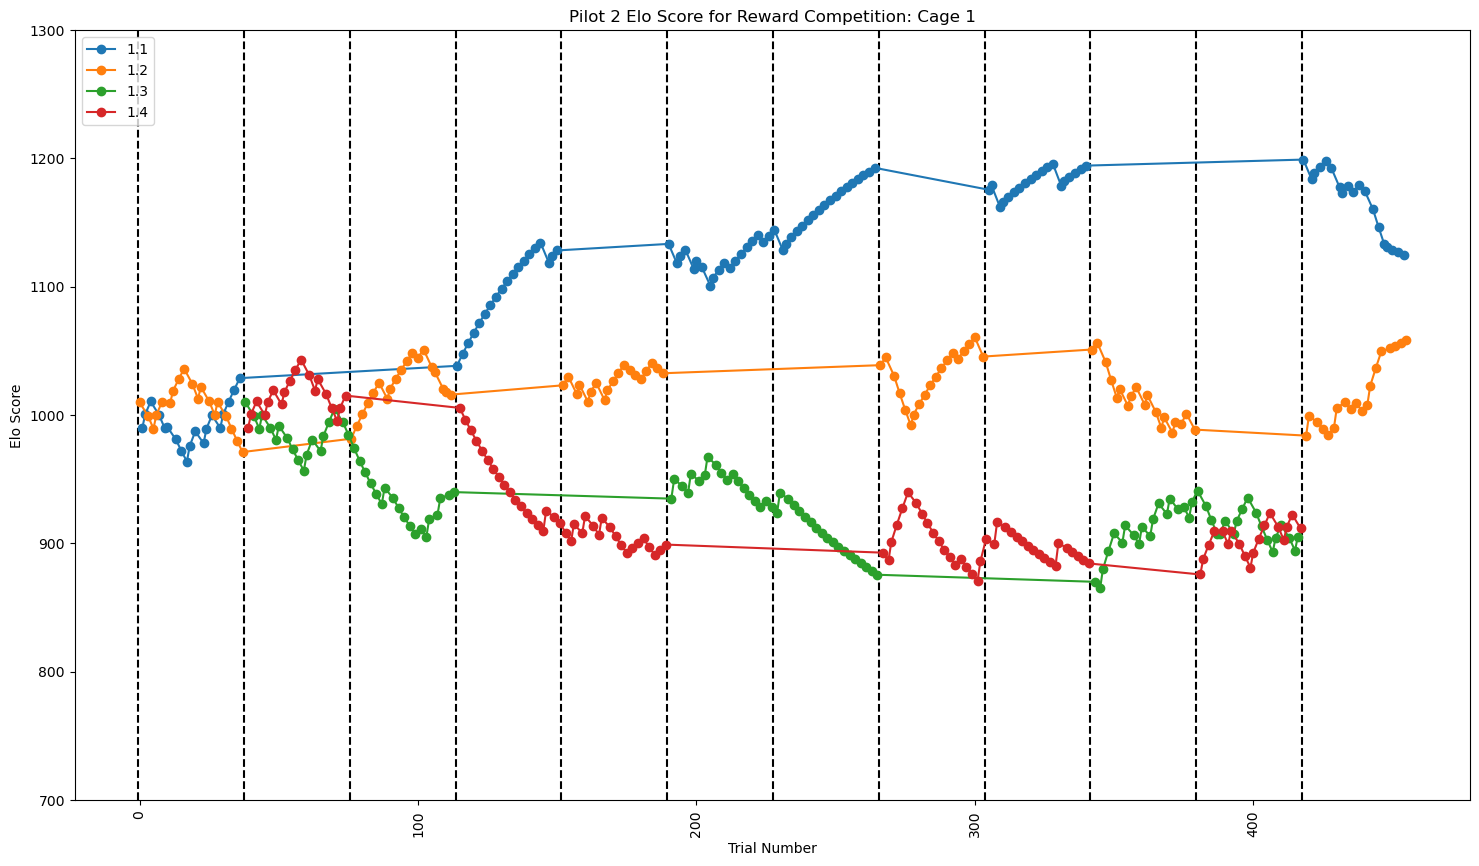

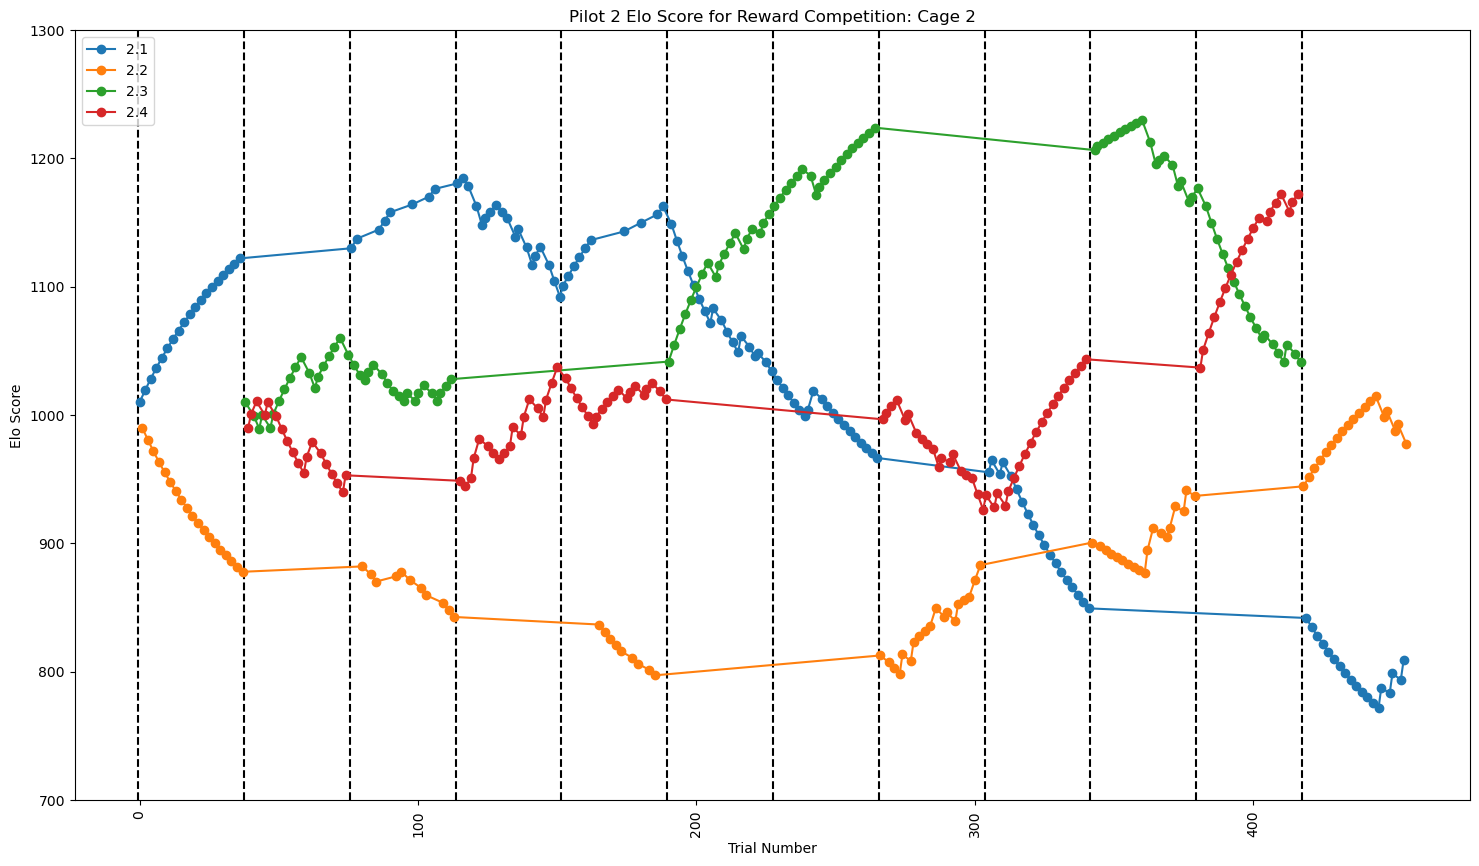

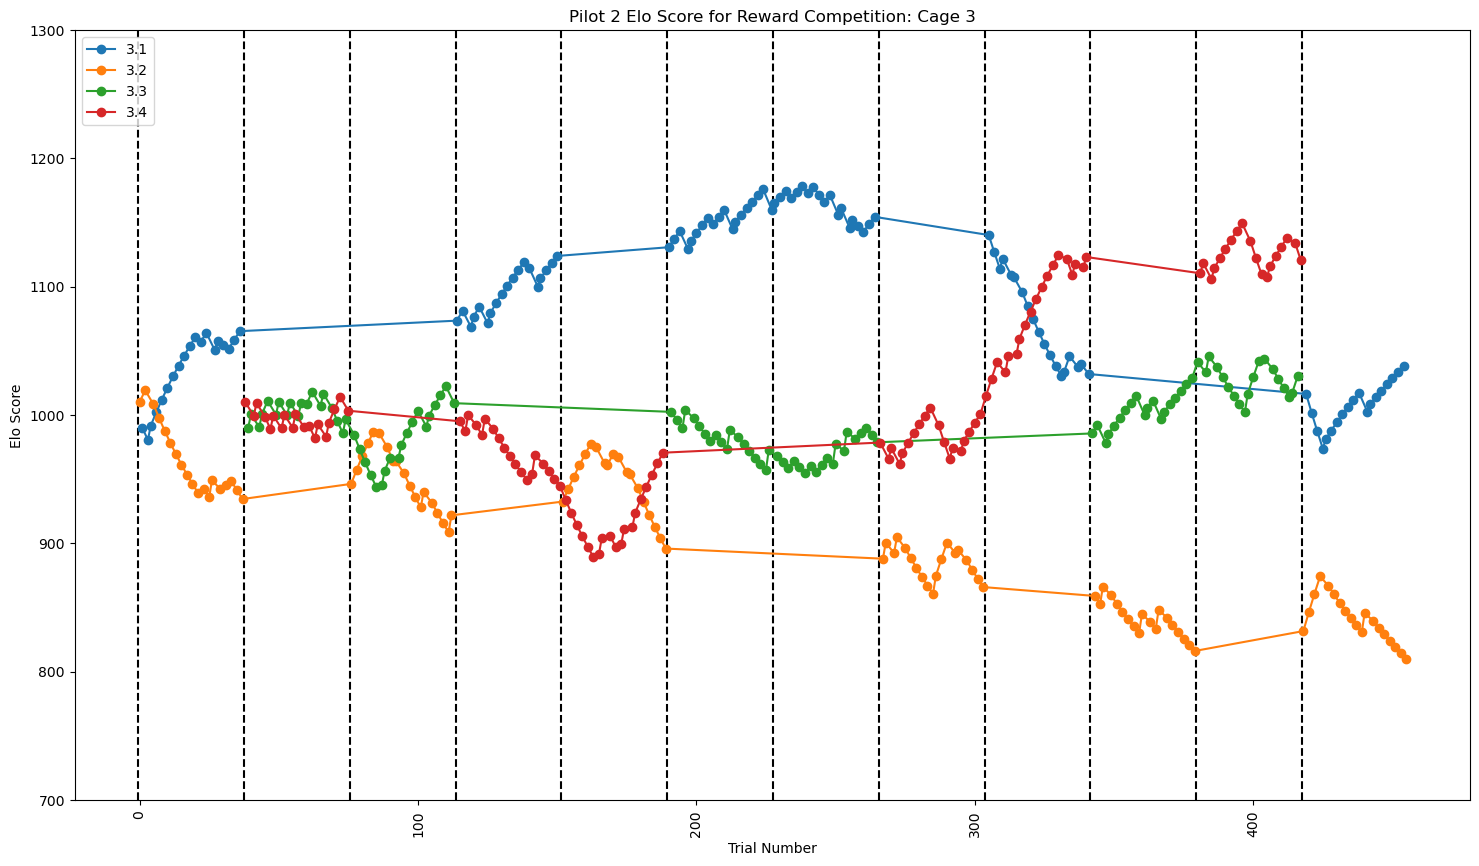

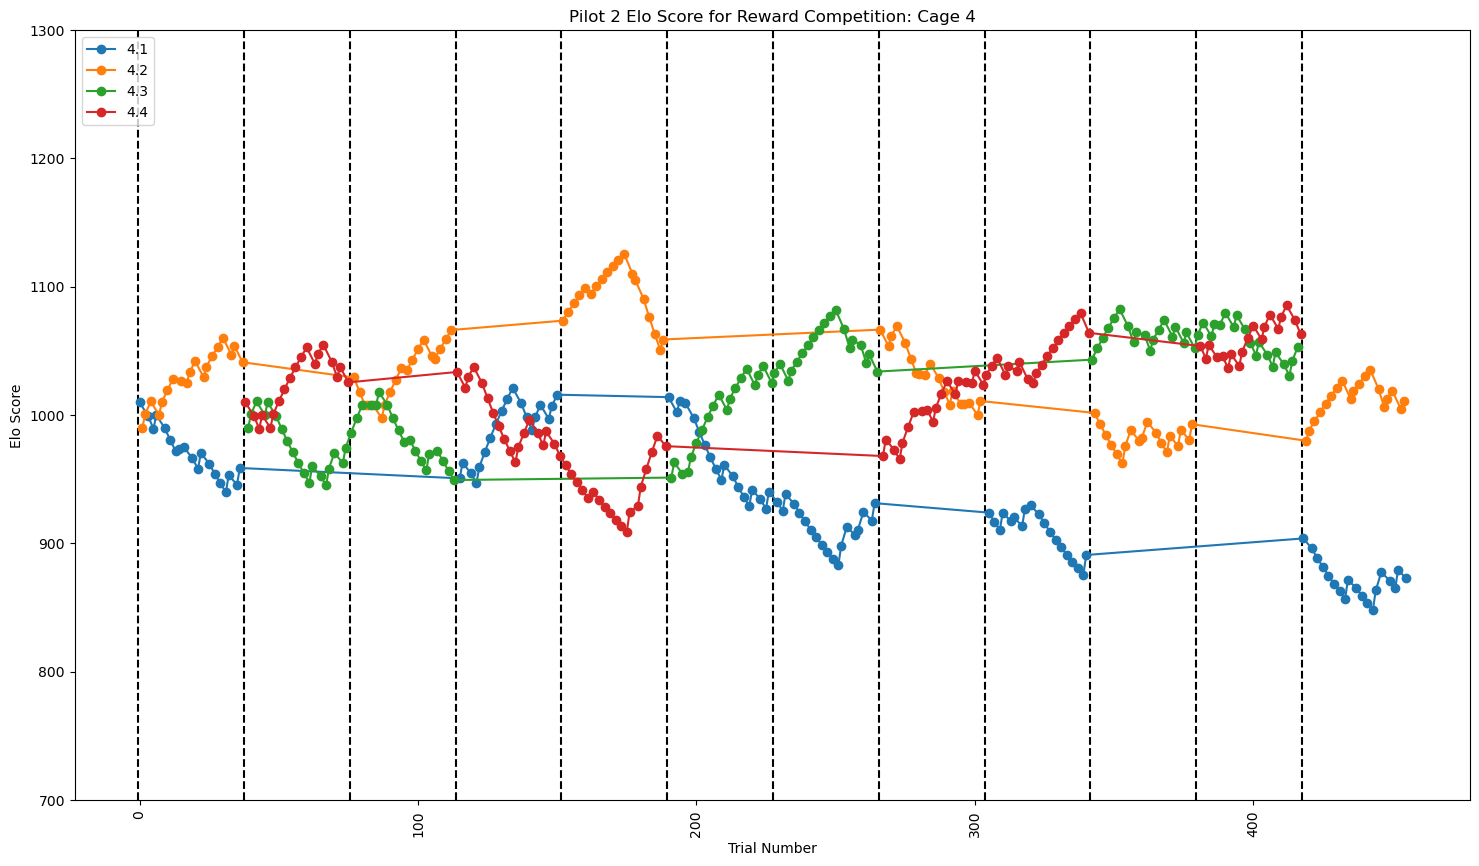

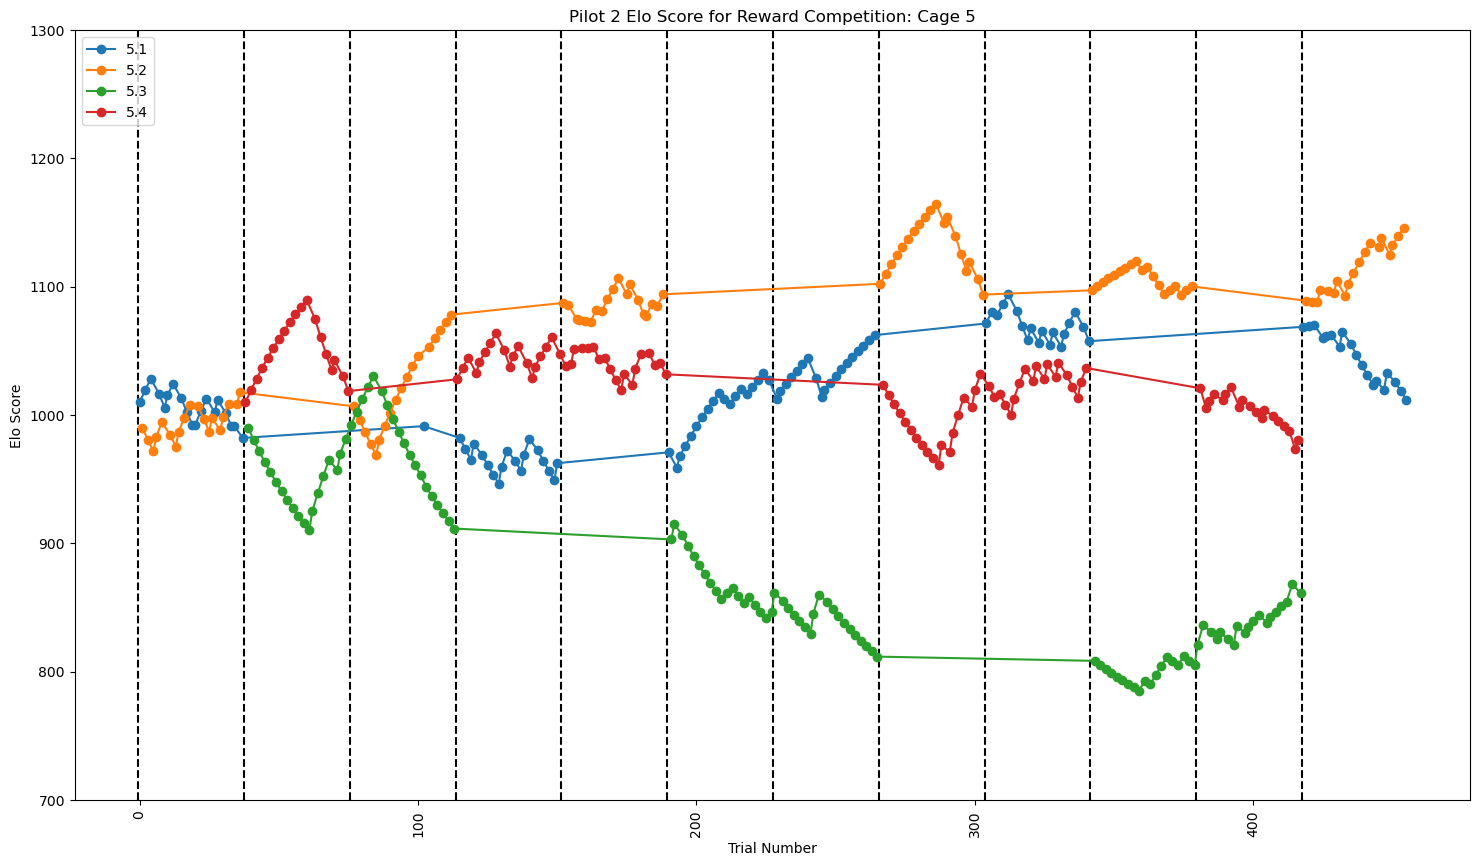

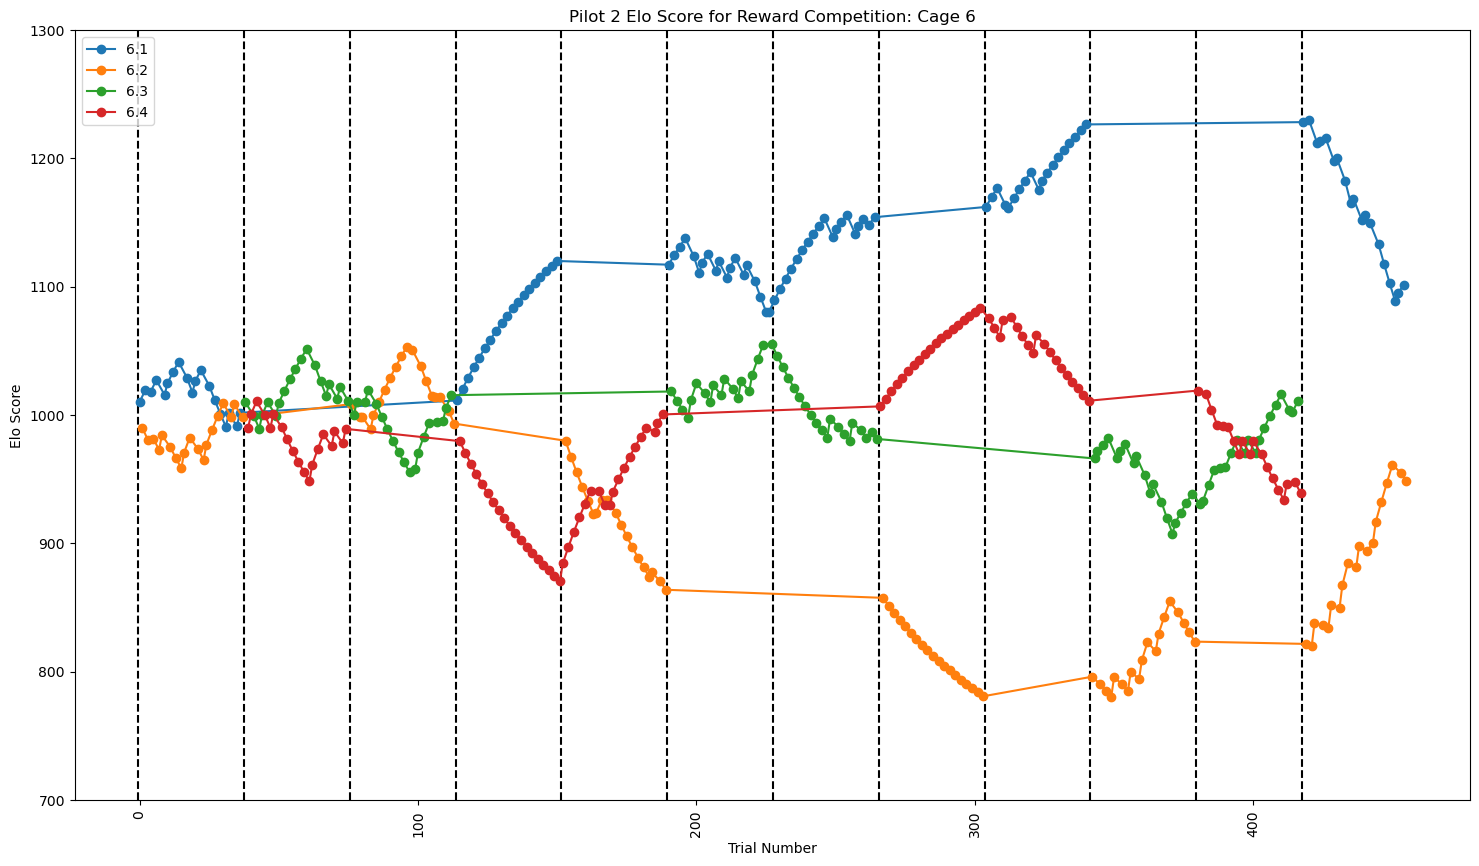

In [121]:
for cage in all_cage_elo_rating_df["cage"].unique():
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (18,10)
    per_cage_df = all_cage_elo_rating_df[all_cage_elo_rating_df["cage"] == cage]
       
    for index in per_cage_df["index"].unique():
        first_session_in_trial = per_cage_df[per_cage_df["index"] == index].iloc[0]["total_trial_number"]
        plt.vlines(x=[first_session_in_trial - 0.5], ymin=700, ymax=1300, colors='black', linestyle='dashed')

    
    
    # Drawing a line for each subject
    for subject in sorted(per_cage_df["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_df = per_cage_df[per_cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        plt.plot(subject_df["total_trial_number"], subject_df["updated_elo_rating"], '-o', label=subject)
    
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("{} Elo Score for {}: Cage {}".format(" ".join(cohort_name.split("_")).capitalize(), string.capwords(" ".join(protocol_name.split("_"))), cage))
    # To show the legend
    ax.legend(loc="upper left")
    plt.xticks(rotation=90)
    plt.ylim(700, 1300) 
    file_name = "{}_{}_elo_rating_{}_date_{}_{}.png".format(cohort_name, protocol_name, cage, earliest_date, latest_date)
    plt.savefig(os.path.join(plot_output_directory, file_name))  
    
    plt.show()

# Saving the Dataframes

In [122]:
elo_rating_spreadsheet_output_directory = os.path.join(".", "proc", "elo_rating_spread_sheets", "{}".format(protocol_name))

In [123]:
elo_rating_spreadsheet_output_directory

'./proc/elo_rating_spread_sheets/reward_competition'

In [124]:
os.makedirs(elo_rating_spreadsheet_output_directory, exist_ok=True)

In [125]:
file_name_parts_separated = [cohort_name, all_cages_string, prefix_name, earliest_date, latest_date]
file_name_parts_combined = "_".join([part for part in file_name_parts_separated if part])

file_name_full = "{}_elo-rating-history.csv".format(file_name_parts_combined)
print(file_name_full)
all_cage_elo_rating_df.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name_full))

pilot_2_cages-1-2-3-4-5-6_rc_20220728_20220729_elo-rating-history.csv


In [126]:
file_name_full = "{}_final-elo-rating.csv".format(file_name_parts_combined)
print(file_name_full)
id_to_final_elo_rating_df.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name_full))

pilot_2_cages-1-2-3-4-5-6_rc_20220728_20220729_final-elo-rating.csv


## Seeing which subject is the dominant or submissive

- Grouping all the rows with the same pair

In [127]:
all_processed_behavior_recording_df = melted_reward_competition_df

In [128]:
all_processed_behavior_recording_df.head()

,index,date,cage,box,match,animal_ids,trial,winner,keep_row,match_is_tie,trial_number,loser,session_number_difference
0,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_1_winner,1.2,True,False,1,1.1,NaN
1,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_2_winner,1.1,True,False,2,1.2,0.0
2,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_3_winner,1.1,True,False,3,1.2,0.0
3,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_4_winner,1.2,True,False,4,1.1,0.0
4,0,2022-07-28,1,1,1.1v1.2,"(1.1, 1.2)",trial_5_winner,1.2,True,False,5,1.1,0.0


In [129]:
all_processed_behavior_recording_df.columns

Index(['index', 'date', 'cage', 'box', 'match', 'animal_ids', 'trial',
       'winner', 'keep_row', 'match_is_tie', 'trial_number', 'loser',
       'session_number_difference'],
      dtype='object')

In [130]:
['date', 'cage', 'match', 'animal_ids', 'trial', 'winner', 'tie', 'loser']

['date', 'cage', 'match', 'animal_ids', 'trial', 'winner', 'tie', 'loser']

- Removing columns that would be unnecessary for the pairings

In [131]:
all_processed_behavior_recording_df = all_processed_behavior_recording_df[['date', 'cage', 'match', 'animal_ids', 'trial', 'winner', 'match_is_tie', 'loser']]
all_processed_behavior_recording_df['processed_cage_number'] = all_processed_behavior_recording_df['cage'].astype(int)

/tmp/ipykernel_979168/3787081151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_processed_behavior_recording_df['processed_cage_number'] = all_processed_behavior_recording_df['cage'].astype(int)


In [132]:
all_processed_behavior_recording_df.head()

,date,cage,match,animal_ids,trial,winner,match_is_tie,loser,processed_cage_number
0,2022-07-28,1,1.1v1.2,"(1.1, 1.2)",trial_1_winner,1.2,False,1.1,1
1,2022-07-28,1,1.1v1.2,"(1.1, 1.2)",trial_2_winner,1.1,False,1.2,1
2,2022-07-28,1,1.1v1.2,"(1.1, 1.2)",trial_3_winner,1.1,False,1.2,1
3,2022-07-28,1,1.1v1.2,"(1.1, 1.2)",trial_4_winner,1.2,False,1.1,1
4,2022-07-28,1,1.1v1.2,"(1.1, 1.2)",trial_5_winner,1.2,False,1.1,1


- Adding a tie to the list of winners and losers if it's a tie

In [133]:
all_processed_behavior_recording_df["winner"] = all_processed_behavior_recording_df.apply(lambda x: "tie" if x["match_is_tie"] else x["winner"], axis=1)
all_processed_behavior_recording_df["loser"] = all_processed_behavior_recording_df.apply(lambda x: "tie" if x["match_is_tie"] else x["loser"], axis=1)

/tmp/ipykernel_979168/2654668465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_processed_behavior_recording_df["winner"] = all_processed_behavior_recording_df.apply(lambda x: "tie" if x["match_is_tie"] else x["winner"], axis=1)
/tmp/ipykernel_979168/2654668465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_processed_behavior_recording_df["loser"] = all_processed_behavior_recording_df.apply(lambda x: "tie" if x["match_is_tie"] else x["loser"], axis=1)


In [134]:
all_processed_behavior_recording_df[all_processed_behavior_recording_df["match_is_tie"]].head()

,date,cage,match,animal_ids,trial,winner,match_is_tie,loser,processed_cage_number
5,2022-07-28,1,1.1v1.2,"(1.1, 1.2)",trial_6_winner,tie,True,tie,1
50,2022-07-28,1,1.2v1.3,"(1.2, 1.3)",trial_13_winner,tie,True,tie,1
53,2022-07-28,1,1.2v1.3,"(1.2, 1.3)",trial_16_winner,tie,True,tie,1
55,2022-07-28,1,1.2v1.3,"(1.2, 1.3)",trial_18_winner,tie,True,tie,1
56,2022-07-28,1,1.2v1.3,"(1.2, 1.3)",trial_19_winner,tie,True,tie,1


- Making a list of all the wins and loses

In [135]:
all_wins_per_pair = all_processed_behavior_recording_df.groupby(["animal_ids", "date"])['winner'].apply(list)
all_loses_per_pair = all_processed_behavior_recording_df.groupby(["animal_ids", "date"])['loser'].apply(list)

In [136]:
all_competition_per_pair_df = pd.concat([all_wins_per_pair, all_loses_per_pair], axis=1).reset_index()

In [137]:
all_competition_per_pair_df = all_competition_per_pair_df.rename(columns={k: "rc_" + k for k in all_competition_per_pair_df.columns})

In [138]:
all_competition_per_pair_df

,rc_animal_ids,rc_date,rc_winner,rc_loser
0,"(1.1, 1.2)",2022-07-28,"[1.2, 1.1, 1.1, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ..."
1,"(1.1, 1.2)",2022-07-29,"[1.1, 1.2, 1.1, 1.1, 1.1, tie, 1.2, tie, 1.1, ...","[1.2, 1.1, 1.2, 1.2, 1.2, tie, 1.1, tie, 1.2, ..."
2,"(1.1, 1.3)",2022-07-28,"[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3, ..."
3,"(1.1, 1.3)",2022-07-29,"[1.1, 1.3, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ..."
4,"(1.1, 1.4)",2022-07-28,"[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ..."
...,...,...,...,...
67,"(6.2, 6.3)",2022-07-29,"[6.2, 6.3, 6.3, 6.3, 6.2, 6.3, 6.3, 6.2, 6.3, ...","[6.3, 6.2, 6.2, 6.2, 6.3, 6.2, 6.2, 6.3, 6.2, ..."
68,"(6.2, 6.4)",2022-07-28,"[6.4, 6.4, 6.4, 6.4, 6.4, 6.4, tie, 6.2, tie, ...","[6.2, 6.2, 6.2, 6.2, 6.2, 6.2, tie, 6.4, tie, ..."
69,"(6.2, 6.4)",2022-07-29,"[6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, ..."
70,"(6.3, 6.4)",2022-07-28,"[6.3, 6.4, 6.4, 6.3, 6.3, 6.4, 6.3, 6.3, 6.3, ...","[6.4, 6.3, 6.3, 6.4, 6.4, 6.3, 6.4, 6.4, 6.4, ..."


- Seeing how often the winners or losers change

In [139]:
# Dropping all the ties
all_competition_per_pair_df["rc_winner_no_ties"] = all_competition_per_pair_df.apply(lambda row: [x for x in row["rc_winner"] if x in row["rc_animal_ids"]], axis=1)
all_competition_per_pair_df["rc_loser_no_ties"] = all_competition_per_pair_df.apply(lambda row: [x for x in row["rc_loser"] if x in row["rc_animal_ids"]], axis=1)

In [140]:
# Comparing the each item with the item after it to see if they are the same of not
all_competition_per_pair_df["rc_different_result_as_previous"] = all_competition_per_pair_df["rc_winner_no_ties"].apply(lambda x: [True if left != right else False for (left, right) in zip(x[1:], x[:-1])])

In [141]:
all_competition_per_pair_df["rc_number_of_switches"] = all_competition_per_pair_df["rc_different_result_as_previous"].apply(lambda x: sum(x))

In [142]:
all_competition_per_pair_df

,rc_animal_ids,rc_date,rc_winner,rc_loser,rc_winner_no_ties,rc_loser_no_ties,rc_different_result_as_previous,rc_number_of_switches
0,"(1.1, 1.2)",2022-07-28,"[1.2, 1.1, 1.1, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, ...","[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2, ...","[True, False, True, False, False, False, False...",7
1,"(1.1, 1.2)",2022-07-29,"[1.1, 1.2, 1.1, 1.1, 1.1, tie, 1.2, tie, 1.1, ...","[1.2, 1.1, 1.2, 1.2, 1.2, tie, 1.1, tie, 1.2, ...","[1.1, 1.2, 1.1, 1.1, 1.1, 1.2, 1.1, 1.1, 1.2, ...","[1.2, 1.1, 1.2, 1.2, 1.2, 1.1, 1.2, 1.2, 1.1, ...","[True, True, False, False, True, True, False, ...",5
2,"(1.1, 1.3)",2022-07-28,"[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3, ...","[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, 1.3, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, 1.1, 1.3, 1.3, ...","[True, True, False, True, True, True, True, Fa...",6
3,"(1.1, 1.3)",2022-07-29,"[1.1, 1.3, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[1.1, 1.3, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[True, True, False, False, False, False, False...",2
4,"(1.1, 1.4)",2022-07-28,"[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...","[False, False, False, False, False, False, Fal...",2
...,...,...,...,...,...,...,...,...
67,"(6.2, 6.3)",2022-07-29,"[6.2, 6.3, 6.3, 6.3, 6.2, 6.3, 6.3, 6.2, 6.3, ...","[6.3, 6.2, 6.2, 6.2, 6.3, 6.2, 6.2, 6.3, 6.2, ...","[6.2, 6.3, 6.3, 6.3, 6.2, 6.3, 6.3, 6.2, 6.3, ...","[6.3, 6.2, 6.2, 6.2, 6.3, 6.2, 6.2, 6.3, 6.2, ...","[True, False, False, True, True, False, True, ...",9
68,"(6.2, 6.4)",2022-07-28,"[6.4, 6.4, 6.4, 6.4, 6.4, 6.4, tie, 6.2, tie, ...","[6.2, 6.2, 6.2, 6.2, 6.2, 6.2, tie, 6.4, tie, ...","[6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.2, 6.4, 6.4, ...","[6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.4, 6.2, 6.2, ...","[False, False, False, False, False, True, True...",2
69,"(6.2, 6.4)",2022-07-29,"[6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, ...","[6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, ...","[False, False, False, False, False, False, Fal...",0
70,"(6.3, 6.4)",2022-07-28,"[6.3, 6.4, 6.4, 6.3, 6.3, 6.4, 6.3, 6.3, 6.3, ...","[6.4, 6.3, 6.3, 6.4, 6.4, 6.3, 6.4, 6.4, 6.4, ...","[6.3, 6.4, 6.4, 6.3, 6.3, 6.4, 6.3, 6.3, 6.3, ...","[6.4, 6.3, 6.3, 6.4, 6.4, 6.3, 6.4, 6.4, 6.4, ...","[True, False, True, False, True, True, False, ...",9


# NOTE: This assumes that Ties aren't the most common outcome for a given pair

## Aggregate all the wins/loses across reward competition sessions

- Getting the average number of switches between winner and loser

In [143]:
# Renaming column to not be confused with previous version
average_switches_per_pair_df = all_competition_per_pair_df.groupby('rc_animal_ids').mean().rename({'rc_number_of_switches': 'rc_average_number_of_switches'}, axis=1)  # new method

/tmp/ipykernel_979168/4041354617.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_switches_per_pair_df = all_competition_per_pair_df.groupby('rc_animal_ids').mean().rename({'rc_number_of_switches': 'rc_average_number_of_switches'}, axis=1)  # new method


- Combining all the trials into one list

In [144]:
all_sessions_per_pair_df = pd.concat([all_competition_per_pair_df.groupby('rc_animal_ids')['rc_winner'].apply(list), all_competition_per_pair_df.groupby('rc_animal_ids')['rc_loser'].apply(list)], axis=1)
all_sessions_per_pair_df = pd.concat([all_sessions_per_pair_df, average_switches_per_pair_df], axis=1)
all_sessions_per_pair_df = all_sessions_per_pair_df.reset_index()

In [145]:
all_sessions_per_pair_df.head()

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches
0,"(1.1, 1.2)","[[1.2, 1.1, 1.1, 1.2, 1.2, tie, 1.2, 1.2, 1.2,...","[[1.1, 1.2, 1.2, 1.1, 1.1, tie, 1.1, 1.1, 1.1,...",6.0
1,"(1.1, 1.3)","[[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1,...","[[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3,...",4.0
2,"(1.1, 1.4)","[[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1,...","[[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,...",3.5
3,"(1.2, 1.3)","[[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2,...","[[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3,...",7.0
4,"(1.2, 1.4)","[[1.2, 1.2, 1.4, 1.2, 1.4, 1.2, 1.2, 1.4, 1.2,...","[[1.4, 1.4, 1.2, 1.4, 1.2, 1.4, 1.4, 1.2, 1.4,...",4.5


- Flattening the list

In [146]:
all_sessions_per_pair_df["rc_winner"] = all_sessions_per_pair_df["rc_winner"].apply(lambda x: [element for innerList in x for element in innerList])
all_sessions_per_pair_df["rc_loser"] = all_sessions_per_pair_df["rc_loser"].apply(lambda x: [element for innerList in x for element in innerList])

In [147]:
all_sessions_per_pair_df.head()

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches
0,"(1.1, 1.2)","[1.2, 1.1, 1.1, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...",6.0
1,"(1.1, 1.3)","[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3, ...",4.0
2,"(1.1, 1.4)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",3.5
3,"(1.2, 1.3)","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, ...",7.0
4,"(1.2, 1.4)","[1.2, 1.2, 1.4, 1.2, 1.4, 1.2, 1.2, 1.4, 1.2, ...","[1.4, 1.4, 1.2, 1.4, 1.2, 1.4, 1.4, 1.2, 1.4, ...",4.5


- Calculating overall winner and loser based on who has the most wins/loses

In [148]:
# Dropping all the ties
all_sessions_per_pair_df["rc_winner_no_ties"] = all_sessions_per_pair_df.apply(lambda row: [x for x in row["rc_winner"] if x in row["rc_animal_ids"]], axis=1)
all_sessions_per_pair_df["rc_loser_no_ties"] = all_sessions_per_pair_df.apply(lambda row: [x for x in row["rc_loser"] if x in row["rc_animal_ids"]], axis=1)

In [149]:
# Putting the first ID for the winner and second for the loser if there is equal number of wins and loses 
all_sessions_per_pair_df["rc_averaged_winner"] = all_sessions_per_pair_df.apply(lambda x: Counter(x["rc_winner_no_ties"]).most_common(1)[0][0] if x["rc_winner_no_ties"].count(Counter(x["rc_winner_no_ties"]).most_common(1)[0][1]) != len(x["rc_winner_no_ties"]) / 2 else x["rc_animal_ids"][0], axis=1)
all_sessions_per_pair_df["rc_averaged_loser"] = all_sessions_per_pair_df.apply(lambda x: Counter(x["rc_loser_no_ties"]).most_common(1)[0][0] if x["rc_loser_no_ties"].count(Counter(x["rc_loser_no_ties"]).most_common(1)[0][1]) != len(x["rc_winner_no_ties"]) / 2 else x["rc_animal_ids"][1], axis=1)


- Checking to see if any of the IDs are the same or are ties

In [150]:
all_sessions_per_pair_df["rc_averaged_loser"].unique()

array(['1.2', '1.3', '1.4', '2.2', '2.1', '2.4', '2.3', '3.2', '3.3',
       '3.4', '4.1', '4.2', '4.4', '4.3', '5.1', '5.3', '5.4', '6.2',
       '6.3', '6.4'], dtype=object)

In [151]:
all_sessions_per_pair_df["rc_averaged_winner"].unique()

array(['1.1', '1.2', '1.4', '2.1', '2.3', '2.4', '3.1', '3.3', '3.4',
       '4.2', '4.3', '4.4', '5.2', '5.1', '5.4', '6.1', '6.3', '6.4'],
      dtype=object)

In [152]:
all_sessions_per_pair_df[all_sessions_per_pair_df["rc_averaged_loser"] == all_sessions_per_pair_df["rc_averaged_winner"]]

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser
10,"(2.2, 2.4)","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.4, 2.4, 2.4, ...","[2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.2, 2.2, 2.2, ...",3.0,"[2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, ...","[2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.2, 2.2, 2.2, ...",2.4,2.4


- Counting the number of wins and loses

In [153]:
all_sessions_per_pair_df["rc_winner_count"] = all_sessions_per_pair_df.apply(lambda x: x["rc_winner"].count(x["rc_averaged_winner"]), axis=1)
all_sessions_per_pair_df["rc_loser_count"] = all_sessions_per_pair_df.apply(lambda x: x["rc_winner"].count(x["rc_averaged_loser"]), axis=1)
all_sessions_per_pair_df["rc_tie_count"] = all_sessions_per_pair_df.apply(lambda x: x["rc_winner"].count("tie"), axis=1)
all_sessions_per_pair_df["rc_all_match_count_including_ties"] = all_sessions_per_pair_df["rc_winner"].apply(lambda x: len(x))

- Comparing the number of wins vs loses

In [154]:
all_sessions_per_pair_df["rc_winner_count_minus_loser_count"] = all_sessions_per_pair_df["rc_winner_count"] - all_sessions_per_pair_df["rc_loser_count"]
# winner number / (winner + loser number with no ties)
all_sessions_per_pair_df["rc_win_to_win_plus_lost_ratio"] = all_sessions_per_pair_df.apply(lambda x: x["rc_winner_count"] / len(x["rc_winner_no_ties"]), axis=1)
# winner number / (winner + loser + tie)
all_sessions_per_pair_df["rc_win_to_all_ratio"] = all_sessions_per_pair_df.apply(lambda x: x["rc_winner_count"] / x["rc_all_match_count_including_ties"], axis=1)
# all_sessions_per_pair_df["rc_is_win_to_all_ratio_tie"] = all_sessions_per_pair_df["rc_win_to_all_ratio"].apply(lambda x: True if x < 0.5 else False)
all_sessions_per_pair_df["rc_is_win_to_win_and_loss_ratio_tie"] = all_sessions_per_pair_df["rc_win_to_win_plus_lost_ratio"].apply(lambda x: True if x < 0.6 else False)

In [155]:
all_sessions_per_pair_df["rc_is_win_to_win_and_loss_ratio_tie"]

0      True
1     False
2     False
3     False
4     False
5      True
6      True
7     False
8     False
9     False
10    False
11     True
12    False
13    False
14     True
15    False
16    False
17     True
18    False
19    False
20     True
21     True
22     True
23     True
24    False
25    False
26     True
27    False
28    False
29    False
30     True
31    False
32    False
33     True
34    False
35    False
Name: rc_is_win_to_win_and_loss_ratio_tie, dtype: bool

- Comparing the number of ties to the number of matches

In [156]:
all_sessions_per_pair_df["rc_tie_to_all_ratio"] = all_sessions_per_pair_df.apply(lambda x: x["rc_tie_count"] / x["rc_all_match_count_including_ties"], axis=1)


In [157]:
all_sessions_per_pair_df[~all_sessions_per_pair_df["rc_is_win_to_win_and_loss_ratio_tie"]]

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio
1,"(1.1, 1.3)","[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3, ...",4.0,"[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, 1.3, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, 1.1, 1.3, 1.3, ...",1.1,1.3,31,4,3,38,27,0.885714,0.815789,False,0.078947
2,"(1.1, 1.4)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",3.5,"[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",1.1,1.4,34,4,0,38,30,0.894737,0.894737,False,0.000000
3,"(1.2, 1.3)","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, ...",7.0,"[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, ...",1.2,1.3,21,12,5,38,9,0.636364,0.552632,False,0.131579
4,"(1.2, 1.4)","[1.2, 1.2, 1.4, 1.2, 1.4, 1.2, 1.2, 1.4, 1.2, ...","[1.4, 1.4, 1.2, 1.4, 1.2, 1.4, 1.4, 1.2, 1.4, ...",4.5,"[1.2, 1.2, 1.4, 1.2, 1.4, 1.2, 1.2, 1.4, 1.2, ...","[1.4, 1.4, 1.2, 1.4, 1.2, 1.4, 1.4, 1.2, 1.4, ...",1.2,1.4,24,8,6,38,16,0.750000,0.631579,False,0.157895
7,"(2.1, 2.3)","[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.1, ...","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.3, ...",3.0,"[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.1, ...","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.3, ...",2.3,2.1,33,3,2,38,30,0.916667,0.868421,False,0.052632
8,"(2.1, 2.4)","[2.1, 2.1, tie, 2.4, 2.4, 2.1, 2.1, 2.1, tie, ...","[2.4, 2.4, tie, 2.1, 2.1, 2.4, 2.4, 2.4, tie, ...",5.5,"[2.1, 2.1, 2.4, 2.4, 2.1, 2.1, 2.1, 2.4, 2.1, ...","[2.4, 2.4, 2.1, 2.1, 2.4, 2.4, 2.4, 2.1, 2.4, ...",2.4,2.1,25,10,3,38,15,0.714286,0.657895,False,0.078947
9,"(2.2, 2.3)","[2.1, 2.1, tie, 2.3, 2.3, 2.1, 2.1, 2.1, tie, ...","[2.3, 2.3, tie, 2.2, 2.2, 2.3, 2.3, 2.3, tie, ...",3.5,"[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.2, ...","[2.3, 2.3, 2.2, 2.2, 2.3, 2.3, 2.3, 2.2, 2.3, ...",2.3,2.2,21,5,4,38,16,0.807692,0.552632,False,0.105263
10,"(2.2, 2.4)","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.4, 2.4, 2.4, ...","[2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.2, 2.2, 2.2, ...",3.0,"[2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, ...","[2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.2, 2.2, 2.2, ...",2.4,2.4,15,15,6,38,0,0.681818,0.394737,False,0.157895
12,"(3.1, 3.2)","[3.2, 3.2, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, ...","[3.1, 3.1, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, ...",3.0,"[3.2, 3.2, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, ...","[3.1, 3.1, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, ...",3.1,3.2,27,8,3,38,19,0.771429,0.710526,False,0.078947
13,"(3.1, 3.3)","[3.1, 3.1, 3.1, 3.3, 3.1, 3.1, 3.1, 3.1, tie, ...","[3.3, 3.3, 3.3, 3.1, 3.3, 3.3, 3.3, 3.3, tie, ...",4.5,"[3.1, 3.1, 3.1, 3.3, 3.1, 3.1, 3.1, 3.1, 3.1, ...","[3.3, 3.3, 3.3, 3.1, 3.3, 3.3, 3.3, 3.3, 3.3, ...",3.1,3.3,26,5,7,38,21,0.838710,0.684211,False,0.184211


In [158]:
all_sessions_per_pair_df.head()

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio
0,"(1.1, 1.2)","[1.2, 1.1, 1.1, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...",6.0,"[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, ...","[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2, ...",1.1,1.2,16,13,9,38,3,0.551724,0.421053,True,0.236842
1,"(1.1, 1.3)","[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3, ...",4.0,"[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, 1.3, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, 1.1, 1.3, 1.3, ...",1.1,1.3,31,4,3,38,27,0.885714,0.815789,False,0.078947
2,"(1.1, 1.4)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",3.5,"[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",1.1,1.4,34,4,0,38,30,0.894737,0.894737,False,0.000000
3,"(1.2, 1.3)","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, ...",7.0,"[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, ...",1.2,1.3,21,12,5,38,9,0.636364,0.552632,False,0.131579
4,"(1.2, 1.4)","[1.2, 1.2, 1.4, 1.2, 1.4, 1.2, 1.2, 1.4, 1.2, ...","[1.4, 1.4, 1.2, 1.4, 1.2, 1.4, 1.4, 1.2, 1.4, ...",4.5,"[1.2, 1.2, 1.4, 1.2, 1.4, 1.2, 1.2, 1.4, 1.2, ...","[1.4, 1.4, 1.2, 1.4, 1.2, 1.4, 1.4, 1.2, 1.4, ...",1.2,1.4,24,8,6,38,16,0.750000,0.631579,False,0.157895


- Checking to see if there are any pairs with more than two sessions

In [159]:
all_sessions_per_pair_df[all_sessions_per_pair_df["rc_all_match_count_including_ties"] > 40]

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio


- Adding the cage information

In [160]:
dropped_cuplicate_all_processed_behavior_recording_df = all_processed_behavior_recording_df[["animal_ids", "processed_cage_number"]].drop_duplicates()

In [161]:
dropped_cuplicate_all_processed_behavior_recording_df

,animal_ids,processed_cage_number
0,"(1.1, 1.2)",1
19,"(1.3, 1.4)",1
38,"(1.2, 1.3)",1
57,"(1.1, 1.4)",1
76,"(1.2, 1.4)",1
95,"(1.1, 1.3)",1
114,"(2.1, 2.2)",2
133,"(2.3, 2.4)",2
152,"(2.2, 2.3)",2
171,"(2.1, 2.4)",2


In [162]:
pair_to_cage = pd.Series(dropped_cuplicate_all_processed_behavior_recording_df["processed_cage_number"].values, index=dropped_cuplicate_all_processed_behavior_recording_df["animal_ids"]).to_dict()

In [163]:
pair_to_cage

{('1.1', '1.2'): 1,
 ('1.3', '1.4'): 1,
 ('1.2', '1.3'): 1,
 ('1.1', '1.4'): 1,
 ('1.2', '1.4'): 1,
 ('1.1', '1.3'): 1,
 ('2.1', '2.2'): 2,
 ('2.3', '2.4'): 2,
 ('2.2', '2.3'): 2,
 ('2.1', '2.4'): 2,
 ('2.2', '2.4'): 2,
 ('2.1', '2.3'): 2,
 ('3.1', '3.2'): 3,
 ('3.3', '3.4'): 3,
 ('3.2', '3.3'): 3,
 ('3.1', '3.4'): 3,
 ('3.2', '3.4'): 3,
 ('3.1', '3.3'): 3,
 ('4.1', '4.2'): 4,
 ('4.3', '4.4'): 4,
 ('4.2', '4.3'): 4,
 ('4.1', '4.4'): 4,
 ('4.2', '4.4'): 4,
 ('4.1', '4.3'): 4,
 ('5.1', '5.2'): 5,
 ('5.3', '5.4'): 5,
 ('5.2', '5.3'): 5,
 ('5.1', '5.4'): 5,
 ('5.2', '5.4'): 5,
 ('5.1', '5.3'): 5,
 ('6.1', '6.2'): 6,
 ('6.3', '6.4'): 6,
 ('6.2', '6.3'): 6,
 ('6.1', '6.4'): 6,
 ('6.2', '6.4'): 6,
 ('6.1', '6.3'): 6}

In [164]:
all_sessions_per_pair_df["processed_cage_number"] = all_sessions_per_pair_df["rc_animal_ids"].map(pair_to_cage)

In [165]:
all_sessions_per_pair_df

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio,processed_cage_number
0,"(1.1, 1.2)","[1.2, 1.1, 1.1, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...",6.0,"[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, ...","[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2, ...",1.1,1.2,16,13,9,38,3,0.551724,0.421053,True,0.236842,1
1,"(1.1, 1.3)","[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3, ...",4.0,"[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, 1.3, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, 1.1, 1.3, 1.3, ...",1.1,1.3,31,4,3,38,27,0.885714,0.815789,False,0.078947,1
2,"(1.1, 1.4)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",3.5,"[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",1.1,1.4,34,4,0,38,30,0.894737,0.894737,False,0.000000,1
3,"(1.2, 1.3)","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, ...",7.0,"[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, ...",1.2,1.3,21,12,5,38,9,0.636364,0.552632,False,0.131579,1
4,"(1.2, 1.4)","[1.2, 1.2, 1.4, 1.2, 1.4, 1.2, 1.2, 1.4, 1.2, ...","[1.4, 1.4, 1.2, 1.4, 1.2, 1.4, 1.4, 1.2, 1.4, ...",4.5,"[1.2, 1.2, 1.4, 1.2, 1.4, 1.2, 1.2, 1.4, 1.2, ...","[1.4, 1.4, 1.2, 1.4, 1.2, 1.4, 1.4, 1.2, 1.4, ...",1.2,1.4,24,8,6,38,16,0.750000,0.631579,False,0.157895,1
5,"(1.3, 1.4)","[1.3, 1.4, 1.4, 1.3, 1.4, 1.4, 1.3, 1.4, 1.4, ...","[1.4, 1.3, 1.3, 1.4, 1.3, 1.3, 1.4, 1.3, 1.3, ...",8.5,"[1.3, 1.4, 1.4, 1.3, 1.4, 1.4, 1.3, 1.4, 1.4, ...","[1.4, 1.3, 1.3, 1.4, 1.3, 1.3, 1.4, 1.3, 1.3, ...",1.4,1.3,21,16,1,38,5,0.567568,0.552632,True,0.026316,1
6,"(2.1, 2.2)","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, ...","[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, ...",2.5,"[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, ...","[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, ...",2.1,2.2,22,16,0,38,6,0.578947,0.578947,True,0.000000,2
7,"(2.1, 2.3)","[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.1, ...","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.3, ...",3.0,"[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.1, ...","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.3, ...",2.3,2.1,33,3,2,38,30,0.916667,0.868421,False,0.052632,2
8,"(2.1, 2.4)","[2.1, 2.1, tie, 2.4, 2.4, 2.1, 2.1, 2.1, tie, ...","[2.4, 2.4, tie, 2.1, 2.1, 2.4, 2.4, 2.4, tie, ...",5.5,"[2.1, 2.1, 2.4, 2.4, 2.1, 2.1, 2.1, 2.4, 2.1, ...","[2.4, 2.4, 2.1, 2.1, 2.4, 2.4, 2.4, 2.1, 2.4, ...",2.4,2.1,25,10,3,38,15,0.714286,0.657895,False,0.078947,2
9,"(2.2, 2.3)","[2.1, 2.1, tie, 2.3, 2.3, 2.1, 2.1, 2.1, tie, ...","[2.3, 2.3, tie, 2.2, 2.2, 2.3, 2.3, 2.3, tie, ...",3.5,"[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.2, ...","[2.3, 2.3, 2.2, 2.2, 2.3, 2.3, 2.3, 2.2, 2.3, ...",2.3,2.2,21,5,4,38,16,0.807692,0.552632,False,0.105263,2


In [166]:
all_sessions_per_pair_df["cohort"] = cohort_name
all_sessions_per_pair_df["processed_cage_number"] = all_sessions_per_pair_df["processed_cage_number"].astype(int).astype(str)

In [167]:
all_sessions_per_pair_df.head()

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio,processed_cage_number,cohort
0,"(1.1, 1.2)","[1.2, 1.1, 1.1, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...",6.0,"[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, ...","[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2, ...",1.1,1.2,16,13,9,38,3,0.551724,0.421053,True,0.236842,1,pilot_2
1,"(1.1, 1.3)","[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3, ...",4.0,"[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, 1.3, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, 1.1, 1.3, 1.3, ...",1.1,1.3,31,4,3,38,27,0.885714,0.815789,False,0.078947,1,pilot_2
2,"(1.1, 1.4)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",3.5,"[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",1.1,1.4,34,4,0,38,30,0.894737,0.894737,False,0.000000,1,pilot_2
3,"(1.2, 1.3)","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, ...",7.0,"[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.3, 1.2, 1.2, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.2, 1.3, 1.3, ...",1.2,1.3,21,12,5,38,9,0.636364,0.552632,False,0.131579,1,pilot_2
4,"(1.2, 1.4)","[1.2, 1.2, 1.4, 1.2, 1.4, 1.2, 1.2, 1.4, 1.2, ...","[1.4, 1.4, 1.2, 1.4, 1.2, 1.4, 1.4, 1.2, 1.4, ...",4.5,"[1.2, 1.2, 1.4, 1.2, 1.4, 1.2, 1.2, 1.4, 1.2, ...","[1.4, 1.4, 1.2, 1.4, 1.2, 1.4, 1.4, 1.2, 1.4, ...",1.2,1.4,24,8,6,38,16,0.750000,0.631579,False,0.157895,1,pilot_2


- Verifying if all the stats are correct

In [168]:
all_sessions_per_pair_df["rc_winner"][0].count(all_sessions_per_pair_df["rc_animal_ids"][0][0])

16

In [169]:
all_sessions_per_pair_df["rc_winner"][0].count(all_sessions_per_pair_df["rc_animal_ids"][1][0])

16

In [170]:
all_sessions_per_pair_df["rc_winner"][0].count("tie")

9

In [171]:
len(all_sessions_per_pair_df["rc_winner"][0])

38

In [172]:
len(all_sessions_per_pair_df["rc_winner_no_ties"][0])

29

In [173]:
all_sessions_per_pair_df.tail()

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio,processed_cage_number,cohort
31,"(6.1, 6.3)","[tie, 6.1, 6.1, 6.1, 6.3, 6.3, 6.1, 6.1, 6.3, ...","[tie, 6.3, 6.3, 6.3, 6.1, 6.1, 6.3, 6.3, 6.1, ...",6.5,"[6.1, 6.1, 6.1, 6.3, 6.3, 6.1, 6.1, 6.3, 6.1, ...","[6.3, 6.3, 6.3, 6.1, 6.1, 6.3, 6.3, 6.1, 6.3, ...",6.1,6.3,25,10,3,38,15,0.714286,0.657895,False,0.078947,6,pilot_2
32,"(6.1, 6.4)","[6.1, 6.1, 6.1, 6.1, 6.1, 6.1, 6.1, 6.1, 6.1, ...","[6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, ...",2.0,"[6.1, 6.1, 6.1, 6.1, 6.1, 6.1, 6.1, 6.1, 6.1, ...","[6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, ...",6.1,6.4,35,2,1,38,33,0.945946,0.921053,False,0.026316,6,pilot_2
33,"(6.2, 6.3)","[6.2, 6.3, tie, 6.3, 6.2, 6.2, 6.2, 6.2, 6.2, ...","[6.3, 6.2, tie, 6.2, 6.3, 6.3, 6.3, 6.3, 6.3, ...",6.0,"[6.2, 6.3, 6.3, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, ...","[6.3, 6.2, 6.2, 6.3, 6.3, 6.3, 6.3, 6.3, 6.3, ...",6.3,6.2,18,16,4,38,2,0.529412,0.473684,True,0.105263,6,pilot_2
34,"(6.2, 6.4)","[6.4, 6.4, 6.4, 6.4, 6.4, 6.4, tie, 6.2, tie, ...","[6.2, 6.2, 6.2, 6.2, 6.2, 6.2, tie, 6.4, tie, ...",1.0,"[6.4, 6.4, 6.4, 6.4, 6.4, 6.4, 6.2, 6.4, 6.4, ...","[6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.4, 6.2, 6.2, ...",6.4,6.2,34,1,3,38,33,0.971429,0.894737,False,0.078947,6,pilot_2
35,"(6.3, 6.4)","[6.3, 6.4, 6.4, 6.3, 6.3, 6.4, 6.3, 6.3, 6.3, ...","[6.4, 6.3, 6.3, 6.4, 6.4, 6.3, 6.4, 6.4, 6.4, ...",8.0,"[6.3, 6.4, 6.4, 6.3, 6.3, 6.4, 6.3, 6.3, 6.3, ...","[6.4, 6.3, 6.3, 6.4, 6.4, 6.3, 6.4, 6.4, 6.4, ...",6.3,6.4,22,12,4,38,10,0.647059,0.578947,False,0.105263,6,pilot_2


# Getting the number of wins per winner and loser

In [174]:
all_competition_per_pair_df["cohort"] = cohort_name

In [175]:
all_competition_per_pair_df["processed_cage_number"] = all_competition_per_pair_df["rc_animal_ids"].map(pair_to_cage).astype(str)

In [176]:
all_competition_per_pair_df["strain"] = all_competition_per_pair_df["processed_cage_number"].map(cage_to_strain)

In [177]:
all_competition_per_pair_df.head()

,rc_animal_ids,rc_date,rc_winner,rc_loser,rc_winner_no_ties,rc_loser_no_ties,rc_different_result_as_previous,rc_number_of_switches,cohort,processed_cage_number,strain
0,"(1.1, 1.2)",2022-07-28,"[1.2, 1.1, 1.1, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, ...","[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2, ...","[True, False, True, False, False, False, False...",7,pilot_2,1,C57
1,"(1.1, 1.2)",2022-07-29,"[1.1, 1.2, 1.1, 1.1, 1.1, tie, 1.2, tie, 1.1, ...","[1.2, 1.1, 1.2, 1.2, 1.2, tie, 1.1, tie, 1.2, ...","[1.1, 1.2, 1.1, 1.1, 1.1, 1.2, 1.1, 1.1, 1.2, ...","[1.2, 1.1, 1.2, 1.2, 1.2, 1.1, 1.2, 1.2, 1.1, ...","[True, True, False, False, True, True, False, ...",5,pilot_2,1,C57
2,"(1.1, 1.3)",2022-07-28,"[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3, ...","[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, 1.3, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, 1.1, 1.3, 1.3, ...","[True, True, False, True, True, True, True, Fa...",6,pilot_2,1,C57
3,"(1.1, 1.3)",2022-07-29,"[1.1, 1.3, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[1.1, 1.3, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[True, True, False, False, False, False, False...",2,pilot_2,1,C57
4,"(1.1, 1.4)",2022-07-28,"[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...","[False, False, False, False, False, False, Fal...",2,pilot_2,1,C57


- Calculating overall winner and loser based on who has the most wins/loses

In [178]:
# Dropping all the ties
all_competition_per_pair_df["rc_winner_no_ties"] = all_competition_per_pair_df.apply(lambda row: [x for x in row["rc_winner"] if x in row["rc_animal_ids"]], axis=1)
all_competition_per_pair_df["rc_loser_no_ties"] = all_competition_per_pair_df.apply(lambda row: [x for x in row["rc_loser"] if x in row["rc_animal_ids"]], axis=1)

In [179]:
# Putting the first ID for the winner and second for the loser if there is equal number of wins and loses 
all_competition_per_pair_df["rc_averaged_winner"] = all_competition_per_pair_df.apply(lambda x: Counter(x["rc_winner_no_ties"]).most_common(1)[0][0] if x["rc_winner_no_ties"].count(Counter(x["rc_winner_no_ties"]).most_common(1)[0][1]) != len(x["rc_winner_no_ties"]) / 2 else x["rc_animal_ids"][0], axis=1)
all_competition_per_pair_df["rc_averaged_loser"] = all_competition_per_pair_df.apply(lambda x: Counter(x["rc_loser_no_ties"]).most_common(1)[0][0] if x["rc_loser_no_ties"].count(Counter(x["rc_loser_no_ties"]).most_common(1)[0][1]) != len(x["rc_winner_no_ties"]) / 2 else x["rc_animal_ids"][1], axis=1)


In [180]:
Counter(all_competition_per_pair_df["rc_winner_no_ties"][0]).most_common(1)[0][1]

10

- Checking to see if any of the IDs are the same or are ties

In [181]:
all_competition_per_pair_df["rc_averaged_loser"].unique()

array(['1.2', '1.3', '1.4', '2.2', '2.1', '2.4', '2.3', '3.2', '3.3',
       '3.4', '3.1', '4.1', '4.4', '4.3', '4.2', '5.1', '5.3', '5.4',
       '6.2', '6.3', '6.4'], dtype=object)

In [182]:
all_competition_per_pair_df["rc_averaged_winner"].unique()

array(['1.1', '1.2', '1.4', '2.1', '2.2', '2.3', '2.4', '3.1', '3.4',
       '3.3', '4.2', '4.3', '4.1', '4.4', '5.2', '5.1', '5.4', '6.1',
       '6.2', '6.3', '6.4'], dtype=object)

- Counting the number of wins and loses

In [183]:
all_competition_per_pair_df["rc_winner_count"] = all_competition_per_pair_df.apply(lambda x: x["rc_winner"].count(x["rc_averaged_winner"]), axis=1)
all_competition_per_pair_df["rc_loser_count"] = all_competition_per_pair_df.apply(lambda x: x["rc_winner"].count(x["rc_averaged_loser"]), axis=1)
all_competition_per_pair_df["rc_tie_count"] = all_competition_per_pair_df.apply(lambda x: x["rc_winner"].count("tie"), axis=1)
all_competition_per_pair_df["rc_all_match_count_including_ties"] = all_competition_per_pair_df["rc_winner"].apply(lambda x: len(x))

In [184]:
all_competition_per_pair_df.head()

,rc_animal_ids,rc_date,rc_winner,rc_loser,rc_winner_no_ties,rc_loser_no_ties,rc_different_result_as_previous,rc_number_of_switches,cohort,processed_cage_number,strain,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties
0,"(1.1, 1.2)",2022-07-28,"[1.2, 1.1, 1.1, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, ...","[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2, ...","[True, False, True, False, False, False, False...",7,pilot_2,1,C57,1.1,1.2,10,8,1,19
1,"(1.1, 1.2)",2022-07-29,"[1.1, 1.2, 1.1, 1.1, 1.1, tie, 1.2, tie, 1.1, ...","[1.2, 1.1, 1.2, 1.2, 1.2, tie, 1.1, tie, 1.2, ...","[1.1, 1.2, 1.1, 1.1, 1.1, 1.2, 1.1, 1.1, 1.2, ...","[1.2, 1.1, 1.2, 1.2, 1.2, 1.1, 1.2, 1.2, 1.1, ...","[True, True, False, False, True, True, False, ...",5,pilot_2,1,C57,1.1,1.2,6,5,8,19
2,"(1.1, 1.3)",2022-07-28,"[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3, ...","[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, 1.3, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, 1.1, 1.3, 1.3, ...","[True, True, False, True, True, True, True, Fa...",6,pilot_2,1,C57,1.1,1.3,13,3,3,19
3,"(1.1, 1.3)",2022-07-29,"[1.1, 1.3, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[1.1, 1.3, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[True, True, False, False, False, False, False...",2,pilot_2,1,C57,1.1,1.3,18,1,0,19
4,"(1.1, 1.4)",2022-07-28,"[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...","[False, False, False, False, False, False, Fal...",2,pilot_2,1,C57,1.1,1.4,18,1,0,19


- Comparing the number of wins vs loses

In [185]:
all_competition_per_pair_df["rc_winner_count_minus_loser_count"] = all_competition_per_pair_df["rc_winner_count"] - all_competition_per_pair_df["rc_loser_count"]
# winner number / (winner + loser number with no ties)
all_competition_per_pair_df["rc_win_to_win_plus_lost_ratio"] = all_competition_per_pair_df.apply(lambda x: x["rc_winner_count"] / len(x["rc_winner_no_ties"]), axis=1)
# winner number / (winner + loser + tie)
all_competition_per_pair_df["rc_win_to_all_ratio"] = all_competition_per_pair_df.apply(lambda x: x["rc_winner_count"] / x["rc_all_match_count_including_ties"], axis=1)
all_competition_per_pair_df["rc_is_win_to_win_and_loss_ratio_tie"] = all_competition_per_pair_df["rc_win_to_win_plus_lost_ratio"].apply(lambda x: True if x < 0.6 else False)

In [186]:
all_competition_per_pair_df["rc_is_win_to_win_and_loss_ratio_tie"]

0      True
1      True
2     False
3     False
4     False
      ...  
67     True
68    False
69    False
70     True
71    False
Name: rc_is_win_to_win_and_loss_ratio_tie, Length: 72, dtype: bool

- Comparing the number of ties to the number of matches

In [187]:
all_competition_per_pair_df["rc_tie_to_all_ratio"] = all_competition_per_pair_df.apply(lambda x: x["rc_tie_count"] / x["rc_all_match_count_including_ties"], axis=1)


In [188]:
all_competition_per_pair_df.head()

,rc_animal_ids,rc_date,rc_winner,rc_loser,rc_winner_no_ties,rc_loser_no_ties,rc_different_result_as_previous,rc_number_of_switches,cohort,processed_cage_number,...,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio
0,"(1.1, 1.2)",2022-07-28,"[1.2, 1.1, 1.1, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1, ...","[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2, ...","[True, False, True, False, False, False, False...",7,pilot_2,1,...,1.2,10,8,1,19,2,0.555556,0.526316,True,0.052632
1,"(1.1, 1.2)",2022-07-29,"[1.1, 1.2, 1.1, 1.1, 1.1, tie, 1.2, tie, 1.1, ...","[1.2, 1.1, 1.2, 1.2, 1.2, tie, 1.1, tie, 1.2, ...","[1.1, 1.2, 1.1, 1.1, 1.1, 1.2, 1.1, 1.1, 1.2, ...","[1.2, 1.1, 1.2, 1.2, 1.2, 1.1, 1.2, 1.2, 1.1, ...","[True, True, False, False, True, True, False, ...",5,pilot_2,1,...,1.2,6,5,8,19,1,0.545455,0.315789,True,0.421053
2,"(1.1, 1.3)",2022-07-28,"[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, tie, 1.3, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, tie, 1.1, 1.3, ...","[1.1, 1.3, 1.1, 1.1, 1.3, 1.1, 1.3, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.1, 1.3, 1.1, 1.3, 1.3, ...","[True, True, False, True, True, True, True, Fa...",6,pilot_2,1,...,1.3,13,3,3,19,10,0.812500,0.684211,False,0.157895
3,"(1.1, 1.3)",2022-07-29,"[1.1, 1.3, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[1.1, 1.3, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.3, 1.1, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, ...","[True, True, False, False, False, False, False...",2,pilot_2,1,...,1.3,18,1,0,19,17,0.947368,0.947368,False,0.000000
4,"(1.1, 1.4)",2022-07-28,"[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...","[False, False, False, False, False, False, Fal...",2,pilot_2,1,...,1.4,18,1,0,19,17,0.947368,0.947368,False,0.000000


- Saving the competition dataframe

In [189]:
file_name = "{}_{}_grouped_by_pairs_cage_{}_date_{}_{}.csv".format(cohort_name, protocol_name, all_cages, earliest_date, latest_date)


In [190]:
elo_rating_spreadsheet_output_directory

'./proc/elo_rating_spread_sheets/reward_competition'

In [191]:
file_name

'pilot_2_reward_competition_grouped_by_pairs_cage_1_2_3_4_5_6_date_20220728_20220729.csv'

In [192]:
file_name = "{}_{}_all_competition_cage_{}_date_{}_{}.csv".format(cohort_name, protocol_name, all_cages, earliest_date, latest_date)


In [193]:
elo_rating_spreadsheet_output_directory

'./proc/elo_rating_spread_sheets/reward_competition'

In [194]:
file_name

'pilot_2_reward_competition_all_competition_cage_1_2_3_4_5_6_date_20220728_20220729.csv'

In [195]:
all_competition_per_pair_df.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name))

# Saving the spreadsheets

In [196]:
file_name = "{}_{}_grouped_by_pairs_cage_{}_date_{}_{}.csv".format(cohort_name, protocol_name, all_cages, earliest_date, latest_date)


In [197]:
elo_rating_spreadsheet_output_directory

'./proc/elo_rating_spread_sheets/reward_competition'

In [198]:
file_name

'pilot_2_reward_competition_grouped_by_pairs_cage_1_2_3_4_5_6_date_20220728_20220729.csv'

In [199]:
all_sessions_per_pair_df.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name))